<a href="https://colab.research.google.com/github/snikhil17/mlzoomcamp/blob/main/Mid-Term%20Project/Sports_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement


BCCI has hired an external analytics consulting firm for data analytics. The major objective of this tie up is to extract actionable insights from the historical match data and make strategic changes to make India win. Primary objective is to create Machine Learning models which correctly predicts a win for the Indian Cricket Team. Once a model is developed then you have to extract actionable insights and recommendation. Also, below are the details of the next 10 matches, India is going to play. You have to predict the result of the matches and if you are getting prediction as a Loss then suggest some changes and re-run your model again until you are getting Win as a prediction. You cannot use the same strategy in the entire series, because opponent will get to know your strategy and they can come with counter strategy. Hence for all the below 5 matches you have to suggest unique strategies to make India win. The suggestions should be in-line with the variables that have been mentioned in the given data set. Do consider the feasibility of the suggestions very carefully as well. 

1. 1 Test match with England in England. All the match are day matches. In England, it will be rainy season at the time to match. 

2. 2 T20 match with Australia in India. All the match are Day and Night matches. In India, it will be winter season at the time to match. 

3. 2 ODI match with Sri Lanka in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.

- extract actionable insights from the historical match data and make strategic changes 
- Primary objective is to create Machine Learning models which correctly predicts a win for the Indian Cricket Team
- You have to predict the result of the matches and if you are getting prediction as a Loss then suggest some changes and re-run your model again until you are getting Win as a prediction.
- You cannot use the same strategy in the entire series, because opponent will get to know your strategy and they can come with counter strategy
    - Hence for all the below 5 matches you have to suggest unique strategies to make India win. 

In [3]:
!pip install optuna

     |████████████████████████████████| 308 kB 5.0 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 209 kB 58.0 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 69.4 MB/s 
     |████████████████████████████████| 144 kB 47.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=95c292276b8994632783f8b9e7ae0f81c664377c8eebb67b3e145914b7218088
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")

from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import preprocessing
from sklearn import metrics

from xgboost import  XGBClassifier


import optuna

In [5]:
# If read.excel doesnt work uncomment and run following code.
!pip install xlrd



### **Upload the file in Files section and then perform following steps**

In [6]:
df_metadata = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Meta data', header = 1, usecols = [1,2])
df_metadata

,Variables,Description
0,Game_number,Unique ID for each match
1,Result,Final result of the match
2,Avg_team_Age,Average age of the playing 11 players for that...
3,Match_light_type,"type of match: Day, night or day & night"
4,Match_format,"Format of the match: T20, ODI or test"
5,Bowlers_in_team,how many full time bowlers has been player in ...
6,Wicket_keeper_in_team,how many full time wicket keeper has been play...
7,All_rounder_in_team,how many full time all rounder has been player...
8,First_selection,First inning of team: batting or bowling
9,Opponent,Opponent team in the match


In [7]:
df_maindata_excel = pd.read_excel('/content/Sports Data.xlsx', sheet_name = 'Sports data for DSBA')
df_maindata_excel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Game_number             2930 non-null   object 
 1   Result                  2930 non-null   object 
 2   Avg_team_Age            2833 non-null   float64
 3   Match_light_type        2878 non-null   object 
 4   Match_format            2860 non-null   object 
 5   Bowlers_in_team         2848 non-null   float64
 6   Wicket_keeper_in_team   2930 non-null   int64  
 7   All_rounder_in_team     2890 non-null   float64
 8   First_selection         2871 non-null   object 
 9   Opponent                2894 non-null   object 
 10  Season                  2868 non-null   object 
 11  Audience_number         2849 non-null   float64
 12  Offshore                2866 non-null   object 
 13  Max_run_scored_1over    2902 non-null   float64
 14  Max_wicket_taken_1over  2930 non-null   

In [8]:
df_maindata_excel["kfold"] = -1

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_maindata_excel)):
    df_maindata_excel.loc[valid_indicies, "kfold"] = fold

df_maindata_excel.to_csv("maindata_folds.csv", index=False)

In [9]:
df_maindata = pd.read_csv('maindata_folds.csv')
df_maindata.head()

,Game_number,Result,Avg_team_Age,Match_light_type,Match_format,Bowlers_in_team,Wicket_keeper_in_team,All_rounder_in_team,First_selection,Opponent,Season,Audience_number,Offshore,Max_run_scored_1over,Max_wicket_taken_1over,Extra_bowls_bowled,Min_run_given_1over,Min_run_scored_1over,Max_run_given_1over,extra_bowls_opponent,player_highest_run,Players_scored_zero,player_highest_wicket,kfold
0,Game_1,Loss,18.0,Day,ODI,3.0,1,3.0,Bowling,Srilanka,Summer,9940.0,No,13.0,3,0.0,2,3.0,6.0,0,54.0,3,1,1
1,Game_2,Win,24.0,Day,T20,3.0,1,4.0,Batting,Zimbabwe,Summer,8400.0,No,12.0,1,0.0,0,3.0,6.0,0,69.0,2,1,4
2,Game_3,Loss,24.0,Day and Night,T20,3.0,1,2.0,Bowling,Zimbabwe,NaN,13146.0,Yes,14.0,4,0.0,0,3.0,6.0,0,69.0,3,1,2
3,Game_4,Win,24.0,NaN,ODI,2.0,1,2.0,Bowling,Kenya,Summer,7357.0,No,15.0,4,0.0,2,3.0,6.0,0,73.0,3,1,3
4,Game_5,Loss,24.0,Night,ODI,1.0,1,3.0,Bowling,Srilanka,Summer,13328.0,No,12.0,4,0.0,0,3.0,6.0,0,80.0,3,1,4


In [10]:
df_maindata.shape

(2930, 24)

In [91]:
df_maindata.describe()

,result,avg_team_age,bowlers_in_team,all_rounder_in_team,max_run_scored_1over,max_wicket_taken_1over,min_run_given_1over,min_run_scored_1over,max_run_given_1over,extra_bowls_opponent,player_highest_run,players_scored_zero,player_highest_wicket,kfold,match_light_type_Day,match_light_type_Day and Night,match_light_type_Night,match_format_ODI,match_format_T20,match_format_Test,first_selection_Batting,first_selection_Bowling,season_Rainy,season_Summer,season_Winter,offshore_No,offshore_Yes
count,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000,2894.000000
mean,0.839323,29.219419,2.908777,2.727367,15.197650,2.715619,1.954734,2.763303,8.634416,4.219419,65.973739,2.730477,2.062889,1.998272,0.715964,0.182792,0.101244,0.659986,0.296821,0.043193,0.391154,0.608846,0.467865,0.313753,0.218383,0.722875,0.277125
std,0.367296,1.737099,1.009789,1.084710,3.649572,1.080409,1.680809,0.703274,4.988380,3.616687,20.215979,0.708394,1.109702,1.412868,0.451032,0.386563,0.301704,0.473795,0.456936,0.203326,0.488093,0.488093,0.499052,0.464097,0.413220,0.447656,0.447656
min,0.000000,24.000000,1.000000,1.000000,11.000000,1.000000,0.000000,1.000000,6.000000,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,30.000000,2.000000,2.000000,12.000000,2.000000,0.000000,2.000000,6.000000,2.000000,48.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,30.000000,3.000000,3.000000,14.000000,3.000000,2.000000,3.000000,6.000000,3.000000,66.000000,3.000000,2.000000,2.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,30.000000,4.000000,4.000000,18.000000,4.000000,3.000000,3.000000,9.000000,7.000000,83.000000,3.000000,3.000000,3.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,30.000000,5.000000,4.000000,25.000000,4.000000,6.000000,4.000000,40.000000,18.000000,100.000000,4.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
df_maindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Game_number             2930 non-null   object 
 1   Result                  2930 non-null   object 
 2   Avg_team_Age            2833 non-null   float64
 3   Match_light_type        2878 non-null   object 
 4   Match_format            2860 non-null   object 
 5   Bowlers_in_team         2848 non-null   float64
 6   Wicket_keeper_in_team   2930 non-null   int64  
 7   All_rounder_in_team     2890 non-null   float64
 8   First_selection         2871 non-null   object 
 9   Opponent                2894 non-null   object 
 10  Season                  2868 non-null   object 
 11  Audience_number         2849 non-null   float64
 12  Offshore                2866 non-null   object 
 13  Max_run_scored_1over    2902 non-null   float64
 14  Max_wicket_taken_1over  2930 non-null   

Observations:

---


- There are missing values. Check them and treat them accordingly
- Player_hightest_wicket and Players_scored_zero is object type convert it into int as it might be useful as int


In [12]:
"""Making columns lower case and replacing any spaces with '_'"""
df_maindata.columns = df_maindata.columns.str.lower().str.replace(' ', '_')

## **Check unique values and convert required columns into Integer type:**

---


- Check the unique values 
- If all values are int then we change it to integer
- Else we convert any string values to int and then convert all values into int type.

In [13]:
for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' '20-20' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' 'Bat' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40.

### **Observations:**

---


- Variables like player_highest_wicket, players_scored_zero, match_format, first_selection has repeated unique values. 
- E.g. player_highest_wicket has 'Three' and 3, which actually means the same. Hence, we will replace 'Three' by 3.
- Similarly for the other variables.
- Finally convert player_hightest_wicket and players_scored_zero to integer

In [14]:
"""Replacing repeated values"""

df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].apply(lambda x: x if (x != 'Three') else 3)
df_maindata['match_format'] = df_maindata['match_format'].apply(lambda x: x if (x != '20-20') else 'T20')
df_maindata['first_selection'] = df_maindata['first_selection'].apply(lambda x: x if (x != 'Bat') else 'Batting')


"""Converting player_highest_wicket and players_scored_zero to integer"""
df_maindata['player_highest_wicket'] = df_maindata['player_highest_wicket'].astype('int')
df_maindata['players_scored_zero'] = df_maindata['players_scored_zero'].astype('int')

for col in df_maindata.columns:
  print(col, '\n',df_maindata[col].unique())
  print()

game_number 
 ['Game_1' 'Game_2' 'Game_3' ... 'Game_2928' 'Game_2929' 'Game_2930']

result 
 ['Loss' 'Win']

avg_team_age 
 [18. 24. nan 17. 12. 25. 26. 27. 28. 29. 30. 70. 69. 50.]

match_light_type 
 ['Day' 'Day and Night' nan 'Night']

match_format 
 ['ODI' 'T20' 'Test' nan]

bowlers_in_team 
 [ 3.  2.  1. nan  4.  5.]

wicket_keeper_in_team 
 [1]

all_rounder_in_team 
 [ 3.  4.  2.  1. nan]

first_selection 
 ['Bowling' 'Batting' nan]

opponent 
 ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England' 'South Africa'
 'Pakistan' 'West Indies' 'Bangladesh' nan]

season 
 ['Summer' nan 'Winter' 'Rainy']

audience_number 
 [ 9940.  8400. 13146. ... 20937. 28756. 14007.]

offshore 
 ['No' 'Yes' nan]

max_run_scored_1over 
 [13. 12. 14. 15. 16. 19. 21. 22. 25. 18. 11. 17. 24. 20. nan 23.]

max_wicket_taken_1over 
 [3 1 4 2]

extra_bowls_bowled 
 [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 17. 31. 13. 26. 24.
 22. 19. 23. 14. 15. 29. 28. 21. 25. 20. 16. 37. 38. 30. 40. 18. 36. 34.
 

In [15]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
avg_team_age,97
bowlers_in_team,82
audience_number,81
match_format,70
offshore,64
season,62
first_selection,59
match_light_type,52
all_rounder_in_team,40
opponent,36


,%age of Missing Values
avg_team_age,0.033110
bowlers_in_team,0.027990
audience_number,0.027650
match_format,0.023890
offshore,0.021840
season,0.021160
first_selection,0.020140
match_light_type,0.017750
all_rounder_in_team,0.013650
opponent,0.012290


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



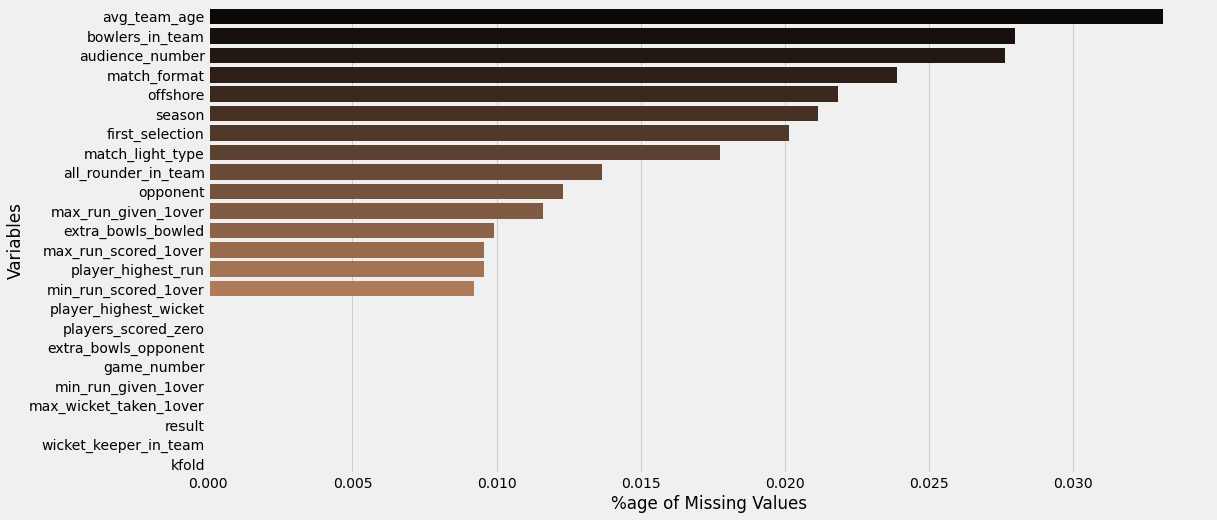

In [16]:
"""Percentage of Missing Values"""
percentage = df_maindata.isnull().mean().round(5).to_frame().rename({0: '%age of Missing Values'}, axis = 1).sort_values(by = '%age of Missing Values', ascending = False)
display(percentage.style.background_gradient('copper_r'))

"""Setting for displaying plot"""
plot_percentage = percentage.reset_index().rename({"index": "Variables"}, axis = 1)
# order = percentage.isnull().mean().round(2).sort_values(ascending =False).index
ax = sns.barplot(plot_percentage['%age of Missing Values'], plot_percentage['Variables'], palette = 'copper')
plt.show()

Observations:
- Missing values in Avg_team_Age, Bowlers_in_team, Audience_number,Match_format ,Offshore, Season,First_selection, Match_light_type ,All_rounder_in_team, Opponent,Max_run_given_1over, Extra_bowls_bowled,player_highest_run,Max_run_scored_1over, Min_run_scored_1over Treat them accordingly
- Avg_team_Age has highest number of missing values.
- **Missing value in Opponent cannot be filled with mode as it might bias our result towards. Best option is to drop those rows**

In [17]:
missing_values_cols = list(plot_percentage[plot_percentage['%age of Missing Values'] != 0]['Variables']) 
missing_cat_cols = [col for col in missing_values_cols if df_maindata[col].dtype == 'object']
missing_num_cols = [col for col in missing_values_cols if col not in missing_cat_cols]
missing_cat_cols

['match_format',
 'offshore',
 'season',
 'first_selection',
 'match_light_type',
 'opponent']

In [18]:
"""Drop rows with missing values in Opponent"""
df_maindata.dropna(subset=['opponent'], inplace = True)

# Now removing Opponent col from list of categorical colummns
missing_cat_cols.remove('opponent')                     

"""Impute Mode for categorical columns"""
for col in missing_cat_cols:
    df_maindata[col].fillna(value=df_maindata[col].mode()[0],inplace=True)

"""Impute mean for numerical columns"""
for col in missing_num_cols:
    df_maindata[col].fillna(value=df_maindata[col].median(),inplace=True)

In [19]:
df_maindata.isnull().sum().to_frame().rename({0: 'Missing Values'}, axis = 1).sort_values(by = 'Missing Values', ascending = False).style.background_gradient('copper_r')

,Missing Values
game_number,0
result,0
player_highest_wicket,0
players_scored_zero,0
player_highest_run,0
extra_bowls_opponent,0
max_run_given_1over,0
min_run_scored_1over,0
min_run_given_1over,0
extra_bowls_bowled,0


Observations:
- Dropped the rows with missing values in Opponent Col 
- Imputed categorical missing values using mode
- Imputed numerical missing values using mean

## **Duplicates?**

In [20]:
df_maindata.duplicated().sum()

0

## **Any Constant Features? They show same value or just one value for all the records in the dataset.**

In [21]:
# Checking constant variables
constant_features = [col for col in df_maindata.columns if df_maindata[col].nunique() == 1]
constant_features

['wicket_keeper_in_team']

In [22]:
# Dropping the constant feature
del df_maindata['wicket_keeper_in_team']

## **Correlation**

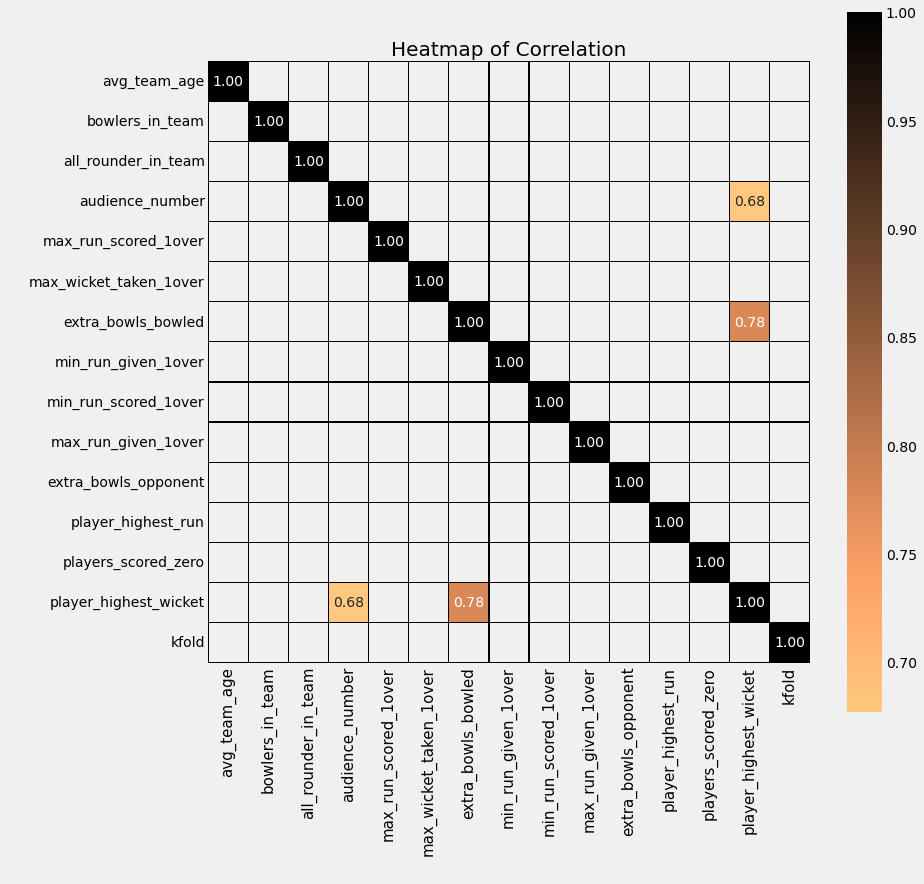

In [23]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(df_maindata.corr(), annot = True, fmt='.2f', mask = df_maindata.corr() < .65, square = True, lw=0.2,linecolor='black' , cmap = 'copper_r')
plt.title("Heatmap of Correlation",fontsize = 20)
plt.xlabel(" ")
plt.ylabel(" ")
plt.xticks(fontsize = 15)
plt.show();

Observations:
- Wicket_keeper_in_team has only one value. Hence we can drop that variable
- Multicollinearity exists between player_highest_wicket and (audience number and extra bowls bowled) at 0.65 as threshold.
- Drop audience number and extra bowls bowled

In [24]:
df_maindata.drop(['audience_number', 'extra_bowls_bowled'], axis = 1, inplace=True)

## **Plotting Categorical Fetures**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



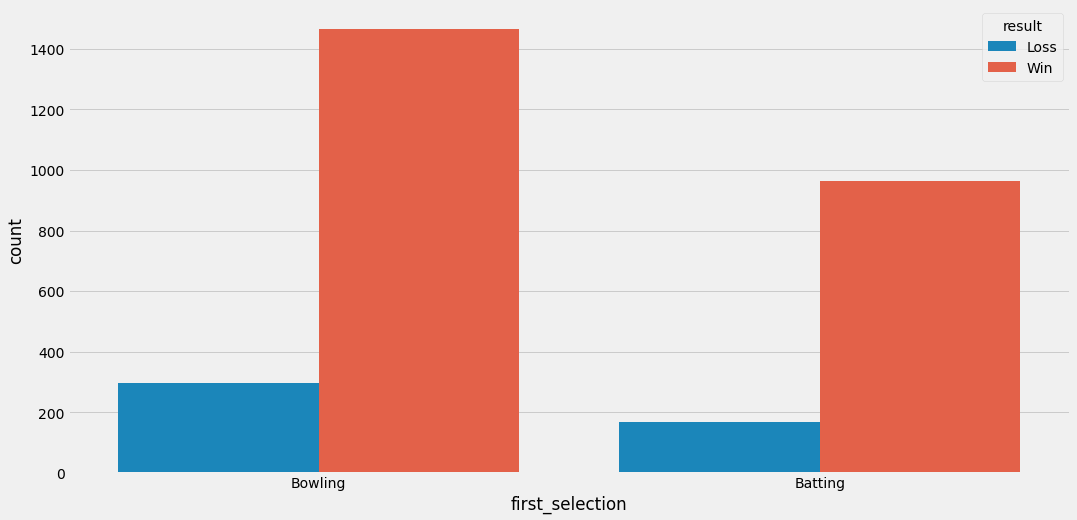

In [25]:
sns.countplot('first_selection', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



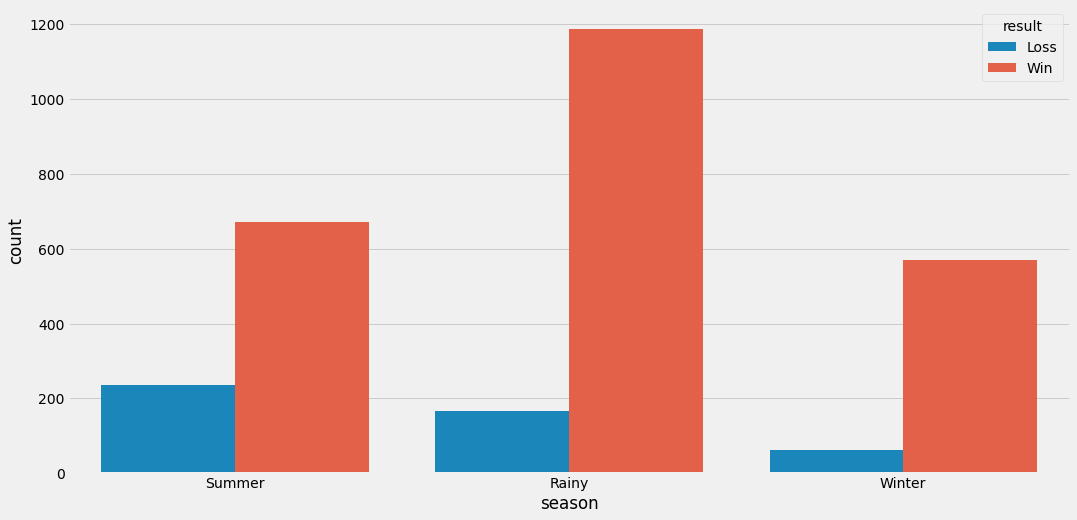

In [26]:
sns.countplot('season', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



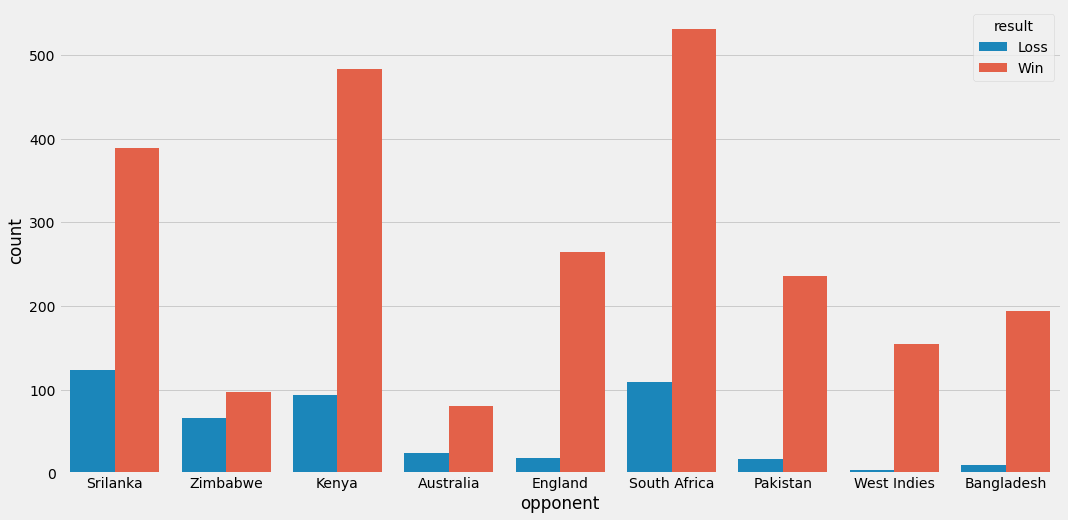

In [27]:
sns.countplot('opponent', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



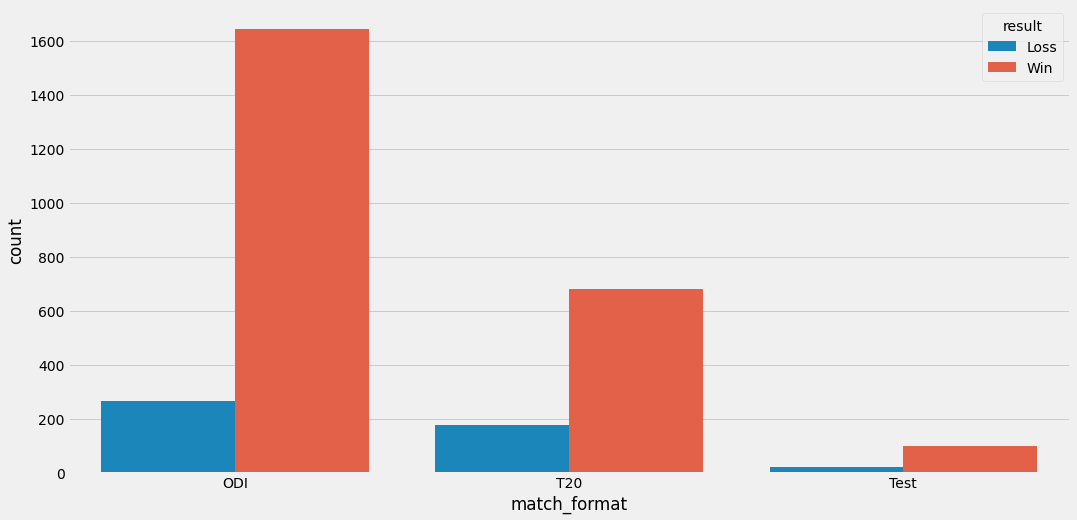

In [28]:
sns.countplot('match_format', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



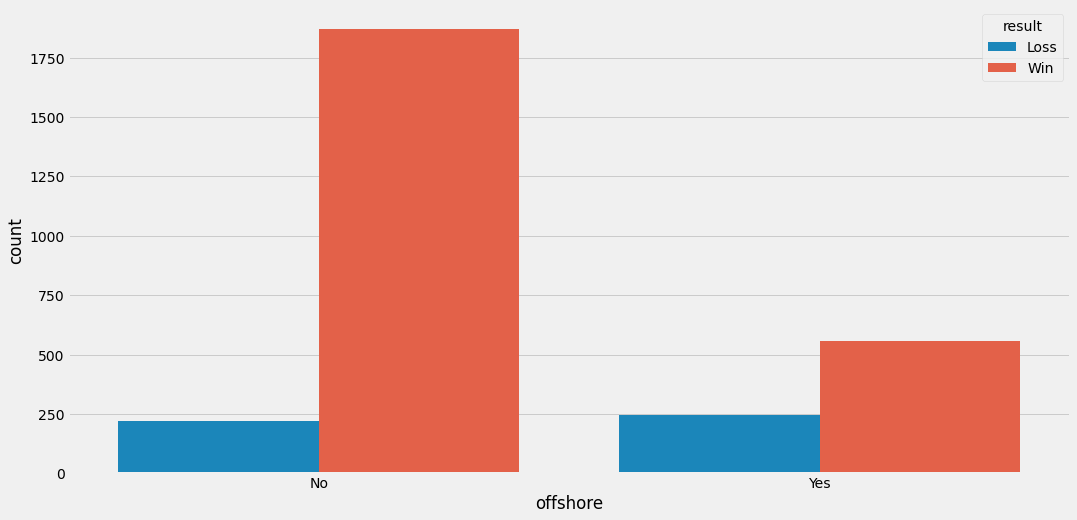

In [29]:
sns.countplot('offshore', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



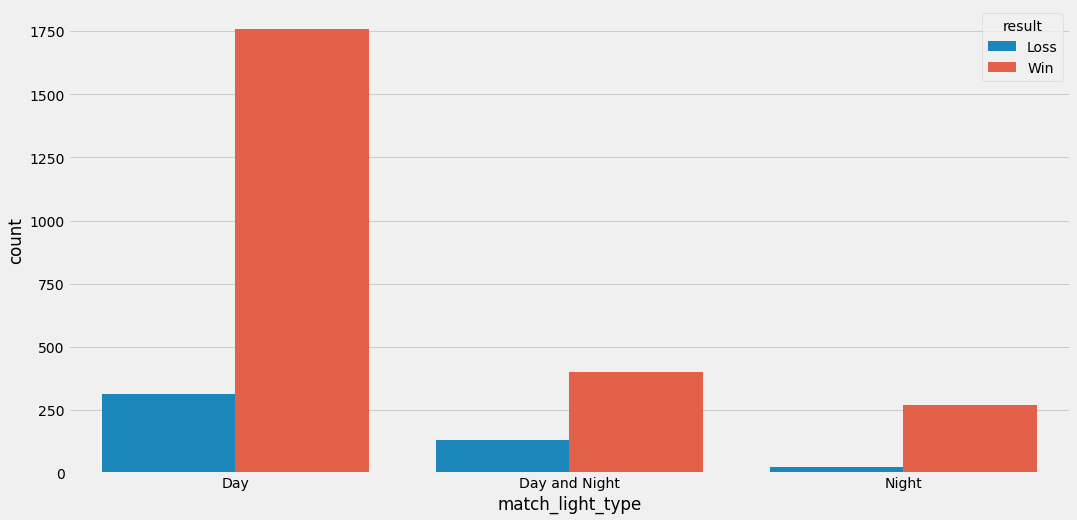

In [30]:
sns.countplot('match_light_type', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



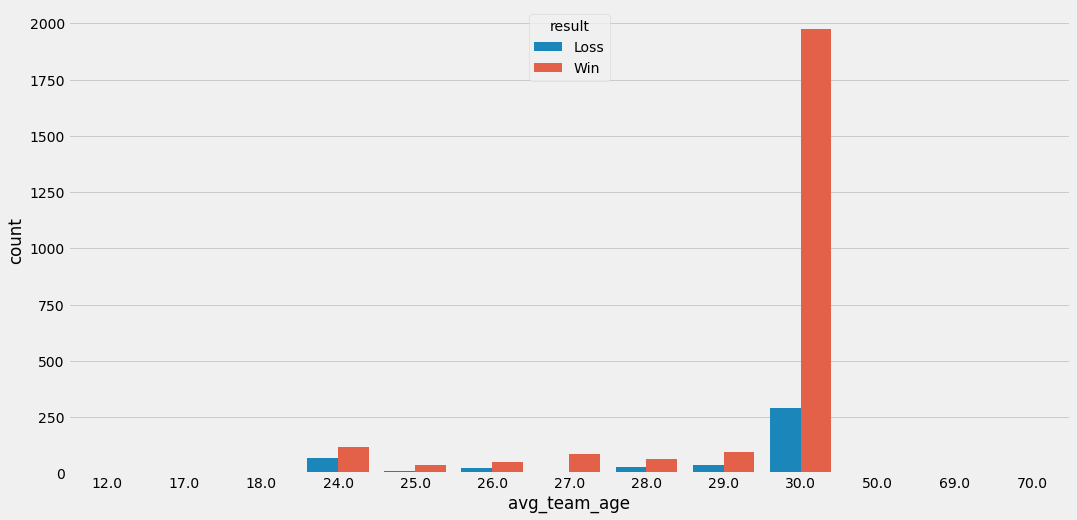

In [31]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

Observation:
- avg_age_team has outliers.
- India win most matches in avg_age 30. 
- Day time matches are beneficial for us.

### **Treating the outliers**
- **Capping and Flooring the outliers**



In [32]:
percentiles = df_maindata['avg_team_age'].quantile([0.01, 0.99]).values
df_maindata['avg_team_age'] = np.clip(df_maindata['avg_team_age'], percentiles[0], percentiles[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



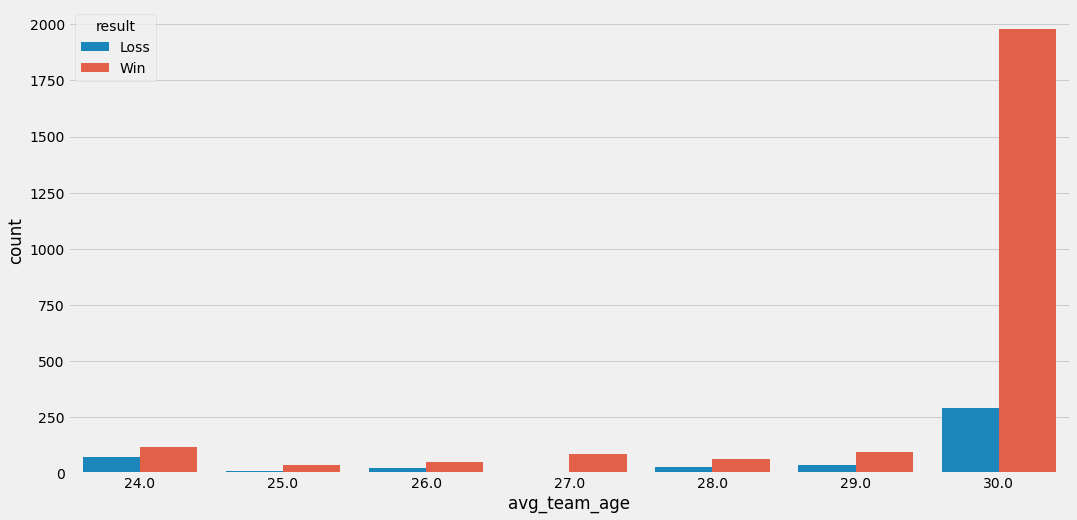

In [33]:
sns.countplot('avg_team_age', hue = 'result' , data = df_maindata)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

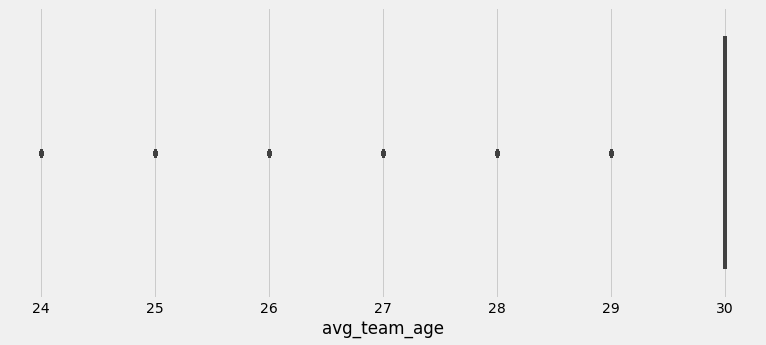

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

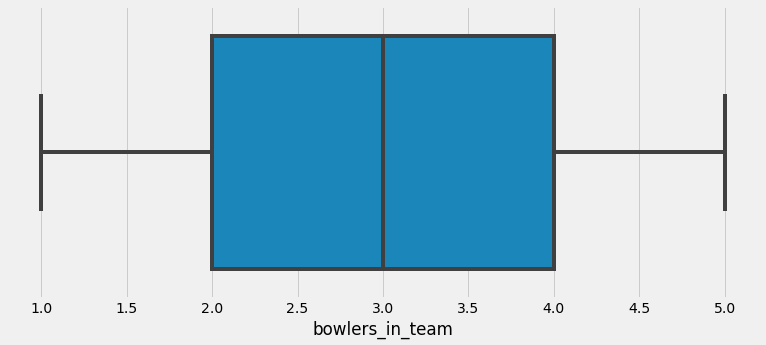

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



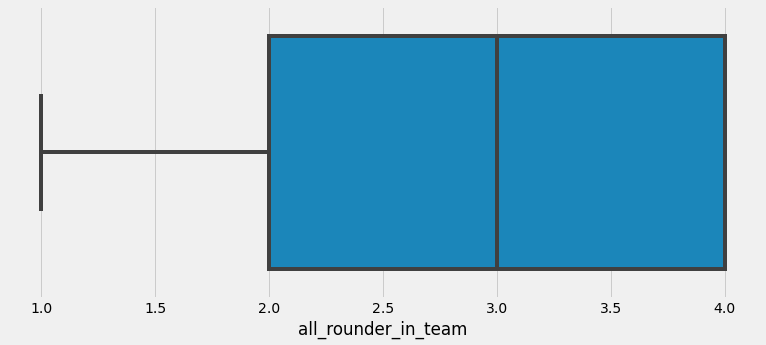

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

<Figure size 864x360 with 0 Axes>

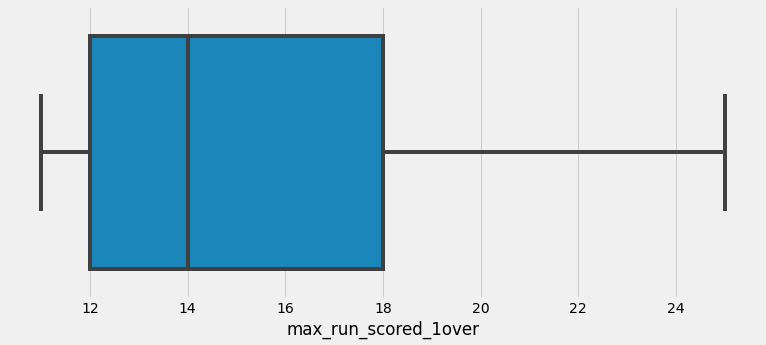

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



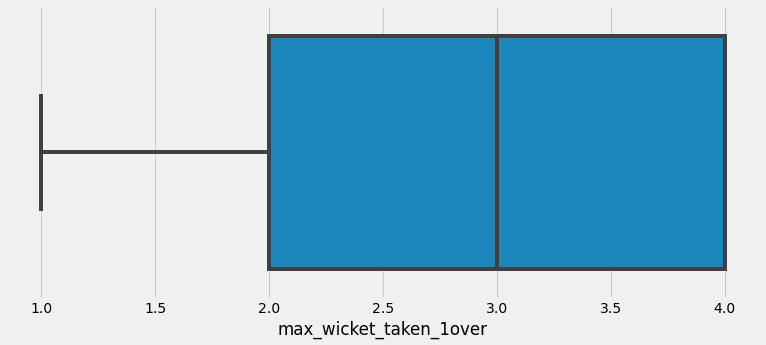

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



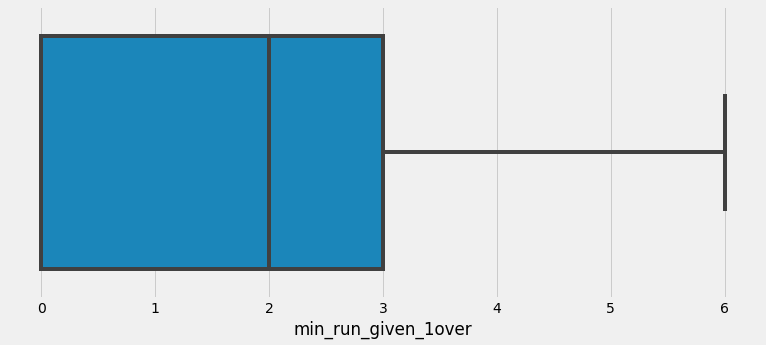

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



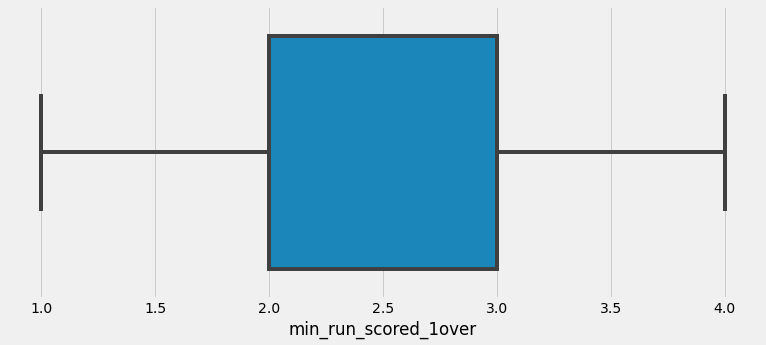

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



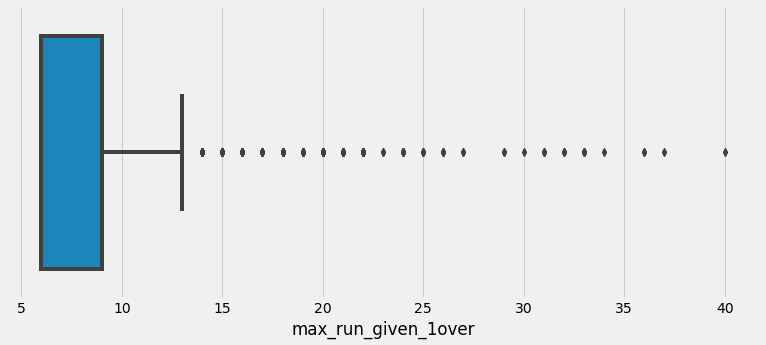

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



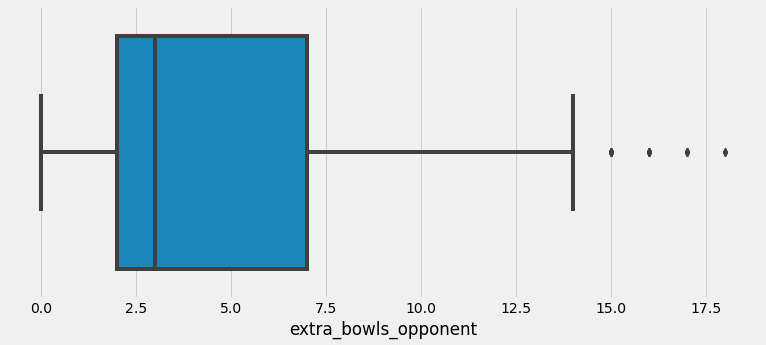

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



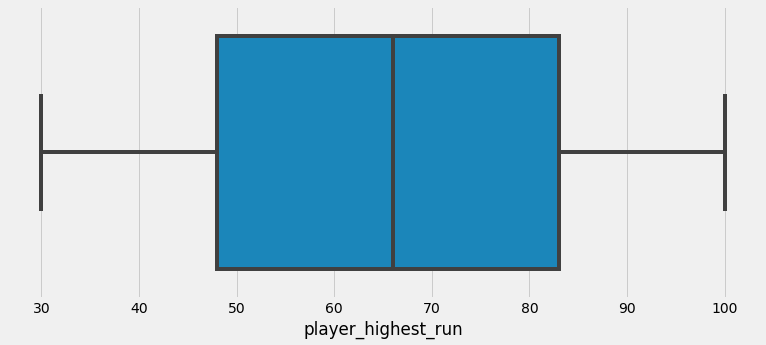

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



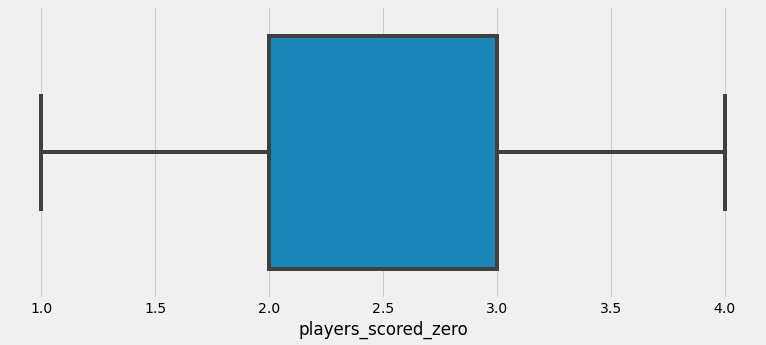

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



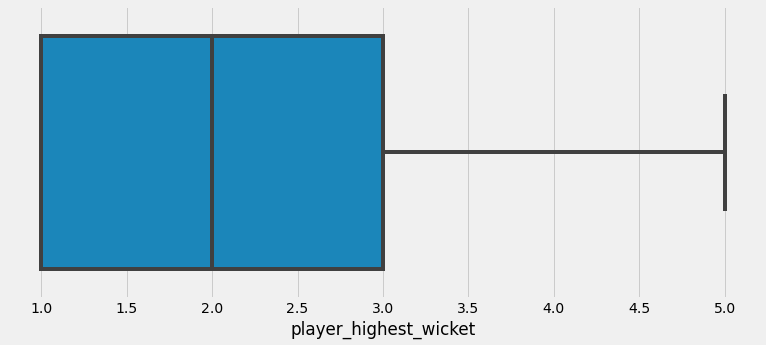

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



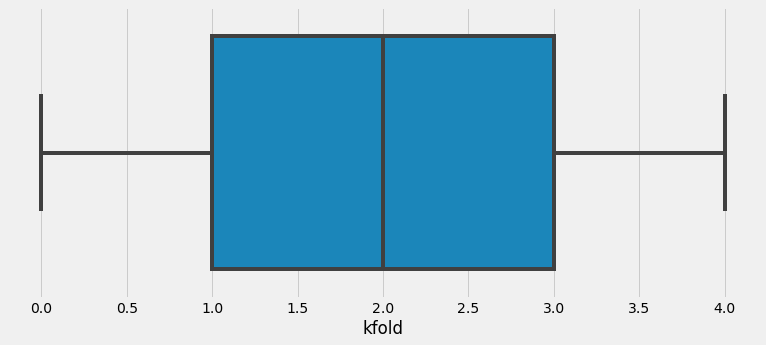

In [34]:
for col in df_maindata.columns:
  plt.figure(figsize = (12,5))
  if df_maindata[col].dtype != 'object':
    sns.boxplot(df_maindata[col])
    plt.show()

## **Let's work with Cardinality**

In [35]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

game_number
First 5 Unique Values: ['Game_1' 'Game_2' 'Game_3' 'Game_4' 'Game_5']
Number of unique values: 2894


result
First 5 Unique Values: ['Loss' 'Win']
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


match_light_type
First 5 Unique Values: ['Day' 'Day and Night' 'Night']
Number of unique values: 3


match_format
First 5 Unique Values: ['ODI' 'T20' 'Test']
Number of unique values: 3


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


first_selection
First 5 Unique Values: ['Bowling' 'Batting']
Number of unique values: 2


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


season
First 5 Unique Values: ['Summer' 'Rainy' 'Winter']
Number of unique values: 3


offshore
First 5 Unique Values: ['No' 'Yes']
Number of unique values: 2


m

### **Observation:**

---
- We can One Hot Encode variables with 3 unique values
- Drop audience_number as it doesn't contribute much towards the predictions.


In [36]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result', 'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

In [37]:
ohe_list = []
for col in df_maindata[useful_cols].columns:
  if df_maindata[useful_cols][col].nunique() <= 3:
    ohe_list.append(col) 

ohe_list

['match_light_type', 'match_format', 'first_selection', 'season', 'offshore']

In [38]:
for col in ohe_list:
  dummies = pd.get_dummies(df_maindata[col], prefix=col)
  df_maindata[dummies.columns] = dummies

In [39]:
df_maindata.drop(ohe_list, axis = 1, inplace=True )
df_maindata.drop('game_number', axis = 1, inplace=True)

In [40]:
df_maindata['result'] = df_maindata['result'].apply(lambda x: 1 if x == 'Win' else 0)

In [41]:
useful_cols = [col for col in df_maindata.columns if col not in ['game_number', 'result' ,'kfold']]
categorical = [col for col in useful_cols if df_maindata[col].dtype == 'object']
numerical = [col for col in useful_cols if col not in categorical]

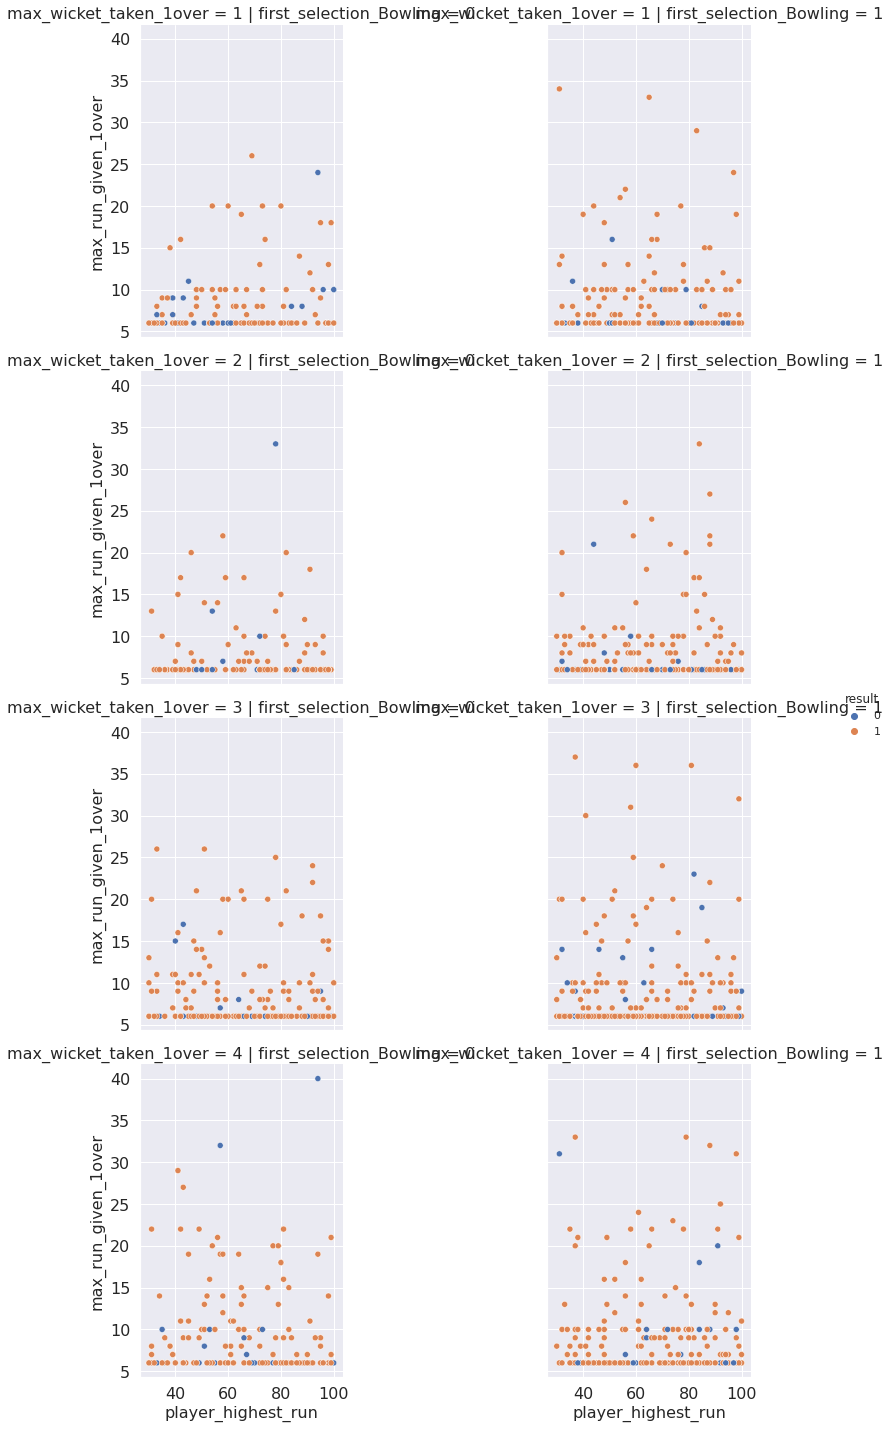

In [46]:
sns.set(rc={'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16})
sns.relplot(x="player_highest_run", y="max_run_given_1over",col="first_selection_Bowling", row="max_wicket_taken_1over", hue='result',  data=df_maindata)
plt.show()

In [43]:
for col in df_maindata.columns:
  print(col)
  print(f"First 5 Unique Values: {df_maindata[col].unique()[:5]}")
  print(f"Number of unique values: {df_maindata[col].nunique()}")

  print('\n')

result
First 5 Unique Values: [0 1]
Number of unique values: 2


avg_team_age
First 5 Unique Values: [24. 30. 25. 26. 27.]
Number of unique values: 7


bowlers_in_team
First 5 Unique Values: [3. 2. 1. 4. 5.]
Number of unique values: 5


all_rounder_in_team
First 5 Unique Values: [3. 4. 2. 1.]
Number of unique values: 4


opponent
First 5 Unique Values: ['Srilanka' 'Zimbabwe' 'Kenya' 'Australia' 'England']
Number of unique values: 9


max_run_scored_1over
First 5 Unique Values: [13. 12. 14. 15. 16.]
Number of unique values: 15


max_wicket_taken_1over
First 5 Unique Values: [3 1 4 2]
Number of unique values: 4


min_run_given_1over
First 5 Unique Values: [2 0 5 4 3]
Number of unique values: 7


min_run_scored_1over
First 5 Unique Values: [3. 4. 1. 2.]
Number of unique values: 4


max_run_given_1over
First 5 Unique Values: [ 6.  7.  8.  9. 10.]
Number of unique values: 31


extra_bowls_opponent
First 5 Unique Values: [0 1 2 3 4]
Number of unique values: 19


player_highest_run
First 5 Un

In [44]:
df, df_test1 = train_test_split(df_maindata, stratify=df_maindata['result'], test_size = 0.15, random_state = 7)

## **HyperTuning first Model**

In [45]:
def run(trial):

    for fold in range(5):
        xtrain =  df_maindata[df_maindata.kfold != fold].reset_index(drop=True)
        xvalid = df_maindata[df_maindata.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        ordinal_encoder = preprocessing.OrdinalEncoder()
        xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
        xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
        
        # Optuna suggest params


        params = {
        'n_estimators': trial.suggest_int('n_estimators', 7000, 9000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_uniform('subsample', 0.50, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.50, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.001)}
        
        model_xgb = XGBClassifier(**params, random_state=7)
        
        
        model_xgb.fit(xtrain, ytrain, early_stopping_rounds=300,eval_set=[(xvalid, yvalid)],  verbose=500)
        
        preds_valid = model_xgb.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=50)

study.best_params

[I 2021-10-29 11:53:57,389] A new study created in memory with name: no-name-8bb03994-9012-4291-b57b-ed531b4fcee8


[0]	validation_0-error:0.147059
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.093426
[1000]	validation_0-error:0.074394
[1500]	validation_0-error:0.055363
Stopping. Best iteration:
[1420]	validation_0-error:0.055363

[0]	validation_0-error:0.155172
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.07931
[1000]	validation_0-error:0.05
[1500]	validation_0-error:0.037931
[2000]	validation_0-error:0.034483
Stopping. Best iteration:
[1754]	validation_0-error:0.034483

[0]	validation_0-error:0.151463
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089501
[1000]	validation_0-error:0.055077
Stopping. Best iteration:
[1176]	validation_0-error:0.046472

[0]	validation_0-error:0.120898
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.069085
[1000]	validation_0-error:0.036269
[1500]	validation_0-error:0.029361
[2000]	

[I 2021-10-29 11:54:49,166] Trial 0 finished with value: 0.938112474618169 and parameters: {'n_estimators': 8814, 'max_depth': 6, 'learning_rate': 0.011254452793029019, 'subsample': 0.6534474185735262, 'colsample_bytree': 0.9576660553276037, 'gamma': 0.0007507941023213276}. Best is trial 0 with value: 0.938112474618169.


[0]	validation_0-error:0.152249
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.117647
[1000]	validation_0-error:0.108997
Stopping. Best iteration:
[902]	validation_0-error:0.107266

[0]	validation_0-error:0.168966
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.12069
[1000]	validation_0-error:0.105172
[1500]	validation_0-error:0.087931
[2000]	validation_0-error:0.072414
[2500]	validation_0-error:0.07069
Stopping. Best iteration:
[2308]	validation_0-error:0.067241

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.123924
[1000]	validation_0-error:0.108434
Stopping. Best iteration:
[778]	validation_0-error:0.108434

[0]	validation_0-error:0.136442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.105354
[1000]	validation_0-error:0.08981
[1500]	validation_0-error:0.067358
[2000]	

[I 2021-10-29 11:55:18,818] Trial 1 finished with value: 0.9292177981813367 and parameters: {'n_estimators': 8896, 'max_depth': 3, 'learning_rate': 0.02139026532614025, 'subsample': 0.8720331552902739, 'colsample_bytree': 0.6126374064553677, 'gamma': 0.00035969194025241194}. Best is trial 0 with value: 0.938112474618169.


[0]	validation_0-error:0.150519
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055363
Stopping. Best iteration:
[205]	validation_0-error:0.050173

[0]	validation_0-error:0.148276
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034483
Stopping. Best iteration:
[275]	validation_0-error:0.032759

[0]	validation_0-error:0.149742
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043029
Stopping. Best iteration:
[245]	validation_0-error:0.039587

[0]	validation_0-error:0.112263
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.018998
Stopping. Best iteration:
[257]	validation_0-error:0.018998

[0]	validation_0-error:0.157986
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[398]	validation_0-error:0.026042



[I 2021-10-29 11:55:30,821] Trial 2 finished with value: 0.935795003089962 and parameters: {'n_estimators': 7067, 'max_depth': 6, 'learning_rate': 0.08270203254237621, 'subsample': 0.950732206114077, 'colsample_bytree': 0.7781038548388227, 'gamma': 0.0007653904172452981}. Best is trial 0 with value: 0.938112474618169.


[0]	validation_0-error:0.15917
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044983
Stopping. Best iteration:
[502]	validation_0-error:0.043253

[0]	validation_0-error:0.141379
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05
Stopping. Best iteration:
[570]	validation_0-error:0.046552

[0]	validation_0-error:0.163511
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
Stopping. Best iteration:
[396]	validation_0-error:0.046472

[0]	validation_0-error:0.132988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031088
Stopping. Best iteration:
[607]	validation_0-error:0.020725

[0]	validation_0-error:0.142361
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.029514
[1000]	validation_0-error:0.026042
Stopping. Best iteration:
[820]	validation_0-error:0.026042



[I 2021-10-29 11:55:46,933] Trial 3 finished with value: 0.9356405049880816 and parameters: {'n_estimators': 7081, 'max_depth': 4, 'learning_rate': 0.09181519877676853, 'subsample': 0.6833459412492315, 'colsample_bytree': 0.8824523439814432, 'gamma': 2.8116186680609112e-05}. Best is trial 0 with value: 0.938112474618169.


[0]	validation_0-error:0.152249
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.103806
[1000]	validation_0-error:0.093426
[1500]	validation_0-error:0.074394
[2000]	validation_0-error:0.064014
[2500]	validation_0-error:0.053633
Stopping. Best iteration:
[2426]	validation_0-error:0.053633

[0]	validation_0-error:0.160345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.1
[1000]	validation_0-error:0.07069
[1500]	validation_0-error:0.053448
[2000]	validation_0-error:0.053448
Stopping. Best iteration:
[1712]	validation_0-error:0.05

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.111876
[1000]	validation_0-error:0.07401
[1500]	validation_0-error:0.060241
Stopping. Best iteration:
[1603]	validation_0-error:0.053356

[0]	validation_0-error:0.132988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	valida

[I 2021-10-29 11:56:12,616] Trial 4 finished with value: 0.9277831729495896 and parameters: {'n_estimators': 8179, 'max_depth': 3, 'learning_rate': 0.04925679375871428, 'subsample': 0.9596390999157742, 'colsample_bytree': 0.5770763150651594, 'gamma': 0.0007619612280523523}. Best is trial 0 with value: 0.938112474618169.


[0]	validation_0-error:0.153979
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.079585
[1000]	validation_0-error:0.057093
Stopping. Best iteration:
[1027]	validation_0-error:0.053633

[0]	validation_0-error:0.165517
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.056897
[1000]	validation_0-error:0.05
Stopping. Best iteration:
[1079]	validation_0-error:0.043103

[0]	validation_0-error:0.153184
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.067126
[1000]	validation_0-error:0.043029
Stopping. Best iteration:
[997]	validation_0-error:0.043029

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036269
[1000]	validation_0-error:0.022453
Stopping. Best iteration:
[919]	validation_0-error:0.022453

[0]	validation_0-error:0.163194
Will train until validation_0-error hasn't improved in

[I 2021-10-29 11:56:39,145] Trial 5 finished with value: 0.9418425002207116 and parameters: {'n_estimators': 8205, 'max_depth': 5, 'learning_rate': 0.03584130859360021, 'subsample': 0.5043646566519093, 'colsample_bytree': 0.6815280537833543, 'gamma': 0.0008024919913939263}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048443
Stopping. Best iteration:
[444]	validation_0-error:0.046713

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039655
Stopping. Best iteration:
[408]	validation_0-error:0.036207

[0]	validation_0-error:0.146299
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[369]	validation_0-error:0.041308

[0]	validation_0-error:0.132988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.025907
Stopping. Best iteration:
[405]	validation_0-error:0.022453

[0]	validation_0-error:0.130208
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034722
Stopping. Best iteration:
[620]	validation_0-error:0.029514



[I 2021-10-29 11:56:52,743] Trial 6 finished with value: 0.9349342279509139 and parameters: {'n_estimators': 8582, 'max_depth': 5, 'learning_rate': 0.07203367433187423, 'subsample': 0.9936615310003144, 'colsample_bytree': 0.9208017371253788, 'gamma': 0.00037722709761454167}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.134948
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[199]	validation_0-error:0.043253

[0]	validation_0-error:0.134483
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039655
Stopping. Best iteration:
[294]	validation_0-error:0.034483

[0]	validation_0-error:0.148021
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041308
Stopping. Best iteration:
[205]	validation_0-error:0.041308

[0]	validation_0-error:0.141623
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.018998
Stopping. Best iteration:
[260]	validation_0-error:0.018998

[0]	validation_0-error:0.144097
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[249]	validation_0-error:0.026042



[I 2021-10-29 11:57:06,288] Trial 7 finished with value: 0.9376269091551162 and parameters: {'n_estimators': 7940, 'max_depth': 6, 'learning_rate': 0.08321102048188055, 'subsample': 0.8006070780356709, 'colsample_bytree': 0.9741316189073475, 'gamma': 0.0008065211445853963}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.16782
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.105536
[1000]	validation_0-error:0.077855
[1500]	validation_0-error:0.058824
Stopping. Best iteration:
[1651]	validation_0-error:0.051903

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.087931
[1000]	validation_0-error:0.068966
[1500]	validation_0-error:0.051724
Stopping. Best iteration:
[1332]	validation_0-error:0.048276

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.096386
[1000]	validation_0-error:0.065404
[1500]	validation_0-error:0.053356
Stopping. Best iteration:
[1260]	validation_0-error:0.049914

[0]	validation_0-error:0.127807
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.072539
[1000]	validation_0-error:0.039724
[1500]	validation_0-error:0.029361
Sto

[I 2021-10-29 11:57:30,895] Trial 8 finished with value: 0.9345590182749184 and parameters: {'n_estimators': 8767, 'max_depth': 3, 'learning_rate': 0.0552542733624516, 'subsample': 0.7728878971066835, 'colsample_bytree': 0.833396645973355, 'gamma': 0.0007223685981963385}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.155709
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.098616
[1000]	validation_0-error:0.067474
[1500]	validation_0-error:0.053633
Stopping. Best iteration:
[1492]	validation_0-error:0.051903

[0]	validation_0-error:0.163793
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089655
[1000]	validation_0-error:0.055172
[1500]	validation_0-error:0.048276
[2000]	validation_0-error:0.044828
Stopping. Best iteration:
[1811]	validation_0-error:0.044828

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.086059
[1000]	validation_0-error:0.056799
[1500]	validation_0-error:0.046472
Stopping. Best iteration:
[1547]	validation_0-error:0.04475

[0]	validation_0-error:0.126079
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062176
[1000]	validation_0-error:0.032815
[15

[I 2021-10-29 11:58:01,615] Trial 9 finished with value: 0.9370751302198287 and parameters: {'n_estimators': 8312, 'max_depth': 4, 'learning_rate': 0.03201201006927076, 'subsample': 0.7356154960358636, 'colsample_bytree': 0.6536547490694085, 'gamma': 0.0006358045931702922}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.077855
[1000]	validation_0-error:0.057093
Stopping. Best iteration:
[877]	validation_0-error:0.057093

[0]	validation_0-error:0.168966
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062069
[1000]	validation_0-error:0.041379
Stopping. Best iteration:
[775]	validation_0-error:0.037931

[0]	validation_0-error:0.156627
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063683
[1000]	validation_0-error:0.048193
Stopping. Best iteration:
[861]	validation_0-error:0.04475

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036269
[1000]	validation_0-error:0.027634
Stopping. Best iteration:
[1059]	validation_0-error:0.022453

[0]	validation_0-error:0.184028
Will train until validation_0-error hasn't improved 

[I 2021-10-29 11:58:23,933] Trial 10 finished with value: 0.9392381036461552 and parameters: {'n_estimators': 7684, 'max_depth': 5, 'learning_rate': 0.040459327455066876, 'subsample': 0.5010999723522136, 'colsample_bytree': 0.5058967910769363, 'gamma': 0.0009289455238238066}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.074394
[1000]	validation_0-error:0.053633
Stopping. Best iteration:
[937]	validation_0-error:0.053633

[0]	validation_0-error:0.168966
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062069
[1000]	validation_0-error:0.044828
Stopping. Best iteration:
[903]	validation_0-error:0.041379

[0]	validation_0-error:0.156627
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065404
[1000]	validation_0-error:0.04475
Stopping. Best iteration:
[871]	validation_0-error:0.04475

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036269
[1000]	validation_0-error:0.027634
Stopping. Best iteration:
[1050]	validation_0-error:0.022453

[0]	validation_0-error:0.184028
Will train until validation_0-error hasn't improved i

[I 2021-10-29 11:58:46,553] Trial 11 finished with value: 0.9411803654983667 and parameters: {'n_estimators': 7670, 'max_depth': 5, 'learning_rate': 0.04017689217586772, 'subsample': 0.5000678208723117, 'colsample_bytree': 0.519662309533339, 'gamma': 0.0009444453772352128}. Best is trial 5 with value: 0.9418425002207116.


[0]	validation_0-error:0.153979
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[494]	validation_0-error:0.048443

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043103
Stopping. Best iteration:
[520]	validation_0-error:0.041379

[0]	validation_0-error:0.153184
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.049914
Stopping. Best iteration:
[490]	validation_0-error:0.048193

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.025907
Stopping. Best iteration:
[553]	validation_0-error:0.022453

[0]	validation_0-error:0.161458
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03125
[1000]	validation_0-error:0.027778
Stopping. Best iteration:
[714]	validation_0-error:0.0277

[I 2021-10-29 11:59:04,049] Trial 12 finished with value: 0.9437185486006885 and parameters: {'n_estimators': 7590, 'max_depth': 5, 'learning_rate': 0.06329400503480033, 'subsample': 0.5035929947760487, 'colsample_bytree': 0.7032732291682329, 'gamma': 0.0009877004326579691}. Best is trial 12 with value: 0.9437185486006885.


[0]	validation_0-error:0.145329
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[432]	validation_0-error:0.051903

[0]	validation_0-error:0.165517
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039655
Stopping. Best iteration:
[515]	validation_0-error:0.032759

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
[1000]	validation_0-error:0.046472
Stopping. Best iteration:
[715]	validation_0-error:0.043029

[0]	validation_0-error:0.131261
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.02418
Stopping. Best iteration:
[549]	validation_0-error:0.018998

[0]	validation_0-error:0.15625
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032986
Stopping. Best iteration:
[593]	validation_0-error:0.027778

[I 2021-10-29 11:59:21,665] Trial 13 finished with value: 0.9366116359141874 and parameters: {'n_estimators': 7473, 'max_depth': 5, 'learning_rate': 0.06507980081735289, 'subsample': 0.5875653532119086, 'colsample_bytree': 0.7036685716264128, 'gamma': 0.0009978131032734464}. Best is trial 12 with value: 0.9437185486006885.


[0]	validation_0-error:0.15917
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[92]	validation_0-error:0.141869

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[17]	validation_0-error:0.12931

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[5]	validation_0-error:0.142857

[0]	validation_0-error:0.143351
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[1]	validation_0-error:0.117444

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[7]	validation_0-error:0.130208



[I 2021-10-29 11:59:27,669] Trial 14 finished with value: 0.779398781672111 and parameters: {'n_estimators': 7401, 'max_depth': 4, 'learning_rate': 0.0030179086374574754, 'subsample': 0.5875131696148816, 'colsample_bytree': 0.7319919621130925, 'gamma': 0.0005528933140686442}. Best is trial 12 with value: 0.9437185486006885.


[0]	validation_0-error:0.16436
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055363
Stopping. Best iteration:
[483]	validation_0-error:0.051903

[0]	validation_0-error:0.155172
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034483
Stopping. Best iteration:
[558]	validation_0-error:0.031034

[0]	validation_0-error:0.163511
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[539]	validation_0-error:0.043029

[0]	validation_0-error:0.136442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[552]	validation_0-error:0.020725

[0]	validation_0-error:0.184028
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.029514
Stopping. Best iteration:
[681]	validation_0-error:0.026042



[I 2021-10-29 11:59:46,233] Trial 15 finished with value: 0.9455283835084313 and parameters: {'n_estimators': 7985, 'max_depth': 5, 'learning_rate': 0.06109320849119277, 'subsample': 0.575281883288503, 'colsample_bytree': 0.8013759173065991, 'gamma': 0.0008944301735173815}. Best is trial 15 with value: 0.9455283835084313.


[0]	validation_0-error:0.17301
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070934
[1000]	validation_0-error:0.048443
Stopping. Best iteration:
[903]	validation_0-error:0.048443

[0]	validation_0-error:0.144828
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041379
Stopping. Best iteration:
[553]	validation_0-error:0.037931

[0]	validation_0-error:0.163511
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055077
Stopping. Best iteration:
[674]	validation_0-error:0.04475

[0]	validation_0-error:0.141623
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036269
[1000]	validation_0-error:0.020725
Stopping. Best iteration:
[835]	validation_0-error:0.020725

[0]	validation_0-error:0.163194
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046875
[1000]	validation_0-err

[I 2021-10-29 12:00:05,632] Trial 16 finished with value: 0.9354860068862011 and parameters: {'n_estimators': 7820, 'max_depth': 4, 'learning_rate': 0.0647204989133511, 'subsample': 0.5806139725017009, 'colsample_bytree': 0.791332156534311, 'gamma': 0.0001287286283736375}. Best is trial 15 with value: 0.9455283835084313.


[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044983
Stopping. Best iteration:
[218]	validation_0-error:0.044983

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[506]	validation_0-error:0.031034

[0]	validation_0-error:0.156627
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
Stopping. Best iteration:
[270]	validation_0-error:0.04475

[0]	validation_0-error:0.126079
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.018998
Stopping. Best iteration:
[503]	validation_0-error:0.017271

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.029514
Stopping. Best iteration:
[325]	validation_0-error:0.026042



[I 2021-10-29 12:00:21,535] Trial 17 finished with value: 0.944137900591507 and parameters: {'n_estimators': 7448, 'max_depth': 6, 'learning_rate': 0.0979761624478826, 'subsample': 0.6504041313771893, 'colsample_bytree': 0.840861694513119, 'gamma': 0.0008808784503775489}. Best is trial 15 with value: 0.9455283835084313.


[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[201]	validation_0-error:0.044983

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[311]	validation_0-error:0.031034

[0]	validation_0-error:0.158348
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046472
Stopping. Best iteration:
[206]	validation_0-error:0.041308

[0]	validation_0-error:0.126079
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[226]	validation_0-error:0.020725

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[273]	validation_0-error:0.026042



[I 2021-10-29 12:00:34,806] Trial 18 finished with value: 0.9459256643418381 and parameters: {'n_estimators': 7277, 'max_depth': 6, 'learning_rate': 0.09377456693493574, 'subsample': 0.655606380464406, 'colsample_bytree': 0.8380857229834997, 'gamma': 0.00044879470976713425}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048443
Stopping. Best iteration:
[381]	validation_0-error:0.039792

[0]	validation_0-error:0.155172
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.02931
Stopping. Best iteration:
[349]	validation_0-error:0.027586

[0]	validation_0-error:0.141136
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043029
Stopping. Best iteration:
[258]	validation_0-error:0.039587

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[305]	validation_0-error:0.018998

[0]	validation_0-error:0.151042
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[351]	validation_0-error:0.026042



[I 2021-10-29 12:00:50,095] Trial 19 finished with value: 0.9377151937847621 and parameters: {'n_estimators': 7241, 'max_depth': 6, 'learning_rate': 0.07759557275520698, 'subsample': 0.7099564442094105, 'colsample_bytree': 0.8684457889590904, 'gamma': 0.0004165147461014949}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.188581
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044983
Stopping. Best iteration:
[214]	validation_0-error:0.041522

[0]	validation_0-error:0.146552
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036207
Stopping. Best iteration:
[400]	validation_0-error:0.031034

[0]	validation_0-error:0.158348
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043029
Stopping. Best iteration:
[243]	validation_0-error:0.043029

[0]	validation_0-error:0.136442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[293]	validation_0-error:0.022453

[0]	validation_0-error:0.145833
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[374]	validation_0-error:0.026042



[I 2021-10-29 12:01:04,423] Trial 20 finished with value: 0.9424604926282333 and parameters: {'n_estimators': 8508, 'max_depth': 6, 'learning_rate': 0.09116312317005625, 'subsample': 0.617570466715204, 'colsample_bytree': 0.7742798516473518, 'gamma': 0.000259327887584052}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[225]	validation_0-error:0.046713

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031034
Stopping. Best iteration:
[579]	validation_0-error:0.027586

[0]	validation_0-error:0.156627
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[227]	validation_0-error:0.041308

[0]	validation_0-error:0.126079
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.018998
Stopping. Best iteration:
[201]	validation_0-error:0.018998

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.027778
Stopping. Best iteration:
[223]	validation_0-error:0.027778



[I 2021-10-29 12:01:18,587] Trial 21 finished with value: 0.9408051558223715 and parameters: {'n_estimators': 7290, 'max_depth': 6, 'learning_rate': 0.0982805112105105, 'subsample': 0.650219805451219, 'colsample_bytree': 0.840328534100457, 'gamma': 0.0005157578310822142}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.15917
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057093
Stopping. Best iteration:
[354]	validation_0-error:0.051903

[0]	validation_0-error:0.153448
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[288]	validation_0-error:0.032759

[0]	validation_0-error:0.142857
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046472
Stopping. Best iteration:
[382]	validation_0-error:0.04475

[0]	validation_0-error:0.146805
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[259]	validation_0-error:0.018998

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[456]	validation_0-error:0.026042



[I 2021-10-29 12:01:35,064] Trial 22 finished with value: 0.9405623730908448 and parameters: {'n_estimators': 7957, 'max_depth': 6, 'learning_rate': 0.09724578303390052, 'subsample': 0.5592429031126286, 'colsample_bytree': 0.905195762887822, 'gamma': 0.0006315104791103437}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16955
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[201]	validation_0-error:0.050173

[0]	validation_0-error:0.160345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[353]	validation_0-error:0.027586

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041308
Stopping. Best iteration:
[325]	validation_0-error:0.039587

[0]	validation_0-error:0.120898
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[260]	validation_0-error:0.018998

[0]	validation_0-error:0.151042
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[311]	validation_0-error:0.026042



[I 2021-10-29 12:01:49,367] Trial 23 finished with value: 0.9428798446190518 and parameters: {'n_estimators': 7458, 'max_depth': 6, 'learning_rate': 0.08664939284132975, 'subsample': 0.6627145911936574, 'colsample_bytree': 0.8170446549457819, 'gamma': 0.0008706523160948497}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.15917
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[415]	validation_0-error:0.046713

[0]	validation_0-error:0.17931
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037931
Stopping. Best iteration:
[408]	validation_0-error:0.034483

[0]	validation_0-error:0.160069
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.049914
Stopping. Best iteration:
[337]	validation_0-error:0.043029

[0]	validation_0-error:0.148532
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[456]	validation_0-error:0.022453

[0]	validation_0-error:0.173611
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.027778
[1000]	validation_0-error:0.026042
Stopping. Best iteration:
[776]	validation_0-error:0.02604

[I 2021-10-29 12:02:05,529] Trial 24 finished with value: 0.9383331861922839 and parameters: {'n_estimators': 7213, 'max_depth': 5, 'learning_rate': 0.07315979296934362, 'subsample': 0.6198506858131193, 'colsample_bytree': 0.7461933156061576, 'gamma': 0.0006236777689204926}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[418]	validation_0-error:0.050173

[0]	validation_0-error:0.139655
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034483
Stopping. Best iteration:
[404]	validation_0-error:0.034483

[0]	validation_0-error:0.142857
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[188]	validation_0-error:0.043029

[0]	validation_0-error:0.139896
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[200]	validation_0-error:0.018998

[0]	validation_0-error:0.140625
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[246]	validation_0-error:0.026042



[I 2021-10-29 12:02:19,132] Trial 25 finished with value: 0.9366778493864218 and parameters: {'n_estimators': 7775, 'max_depth': 6, 'learning_rate': 0.0982097808882198, 'subsample': 0.8192600566861967, 'colsample_bytree': 0.8526841824879424, 'gamma': 0.0002632452105836263}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.17128
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.055363
Stopping. Best iteration:
[620]	validation_0-error:0.046713

[0]	validation_0-error:0.158621
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.037931
Stopping. Best iteration:
[582]	validation_0-error:0.032759

[0]	validation_0-error:0.151463
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[553]	validation_0-error:0.041308

[0]	validation_0-error:0.145078
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031088
Stopping. Best iteration:
[673]	validation_0-error:0.022453

[0]	validation_0-error:0.151042
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036458
[1000]	validation_0-error:0.026042
Stopping. Best iteration:
[946]	validation_0-error:0.02604

[I 2021-10-29 12:02:40,237] Trial 26 finished with value: 0.934404520173038 and parameters: {'n_estimators': 7023, 'max_depth': 5, 'learning_rate': 0.053383806031372494, 'subsample': 0.55466473239629, 'colsample_bytree': 0.8004126748975406, 'gamma': 0.0008813100841401479}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.143599
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[207]	validation_0-error:0.050173

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031034
Stopping. Best iteration:
[538]	validation_0-error:0.02931

[0]	validation_0-error:0.151463
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043029
Stopping. Best iteration:
[481]	validation_0-error:0.043029

[0]	validation_0-error:0.138169
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[256]	validation_0-error:0.018998

[0]	validation_0-error:0.144097
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[316]	validation_0-error:0.026042



[I 2021-10-29 12:02:57,063] Trial 27 finished with value: 0.9396353844795622 and parameters: {'n_estimators': 7578, 'max_depth': 6, 'learning_rate': 0.0788307859996988, 'subsample': 0.6928132666592686, 'colsample_bytree': 0.9396483043062865, 'gamma': 0.0004821877535968626}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16436
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[196]	validation_0-error:0.046713

[0]	validation_0-error:0.203448
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[428]	validation_0-error:0.02931

[0]	validation_0-error:0.160069
Will train until validation_0-error hasn't improved in 300 rounds.
Stopping. Best iteration:
[177]	validation_0-error:0.04475

[0]	validation_0-error:0.136442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[229]	validation_0-error:0.020725

[0]	validation_0-error:0.154514
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[294]	validation_0-error:0.026042



[I 2021-10-29 12:03:09,784] Trial 28 finished with value: 0.9397898825814425 and parameters: {'n_estimators': 8100, 'max_depth': 6, 'learning_rate': 0.08960120696093826, 'subsample': 0.7304430437516974, 'colsample_bytree': 0.7617126561350367, 'gamma': 0.0006817828475432235}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.148789
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065744
Stopping. Best iteration:
[666]	validation_0-error:0.053633

[0]	validation_0-error:0.146552
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05
[1000]	validation_0-error:0.036207
Stopping. Best iteration:
[1011]	validation_0-error:0.034483

[0]	validation_0-error:0.151463
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053356
Stopping. Best iteration:
[668]	validation_0-error:0.043029

[0]	validation_0-error:0.131261
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032815
[1000]	validation_0-error:0.020725
Stopping. Best iteration:
[967]	validation_0-error:0.020725

[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039931
[1000]	validation_0-erro

[I 2021-10-29 12:03:41,899] Trial 29 finished with value: 0.940385803831553 and parameters: {'n_estimators': 7353, 'max_depth': 6, 'learning_rate': 0.02614454030068506, 'subsample': 0.6337937475768758, 'colsample_bytree': 0.9966451753798338, 'gamma': 0.0002402281595985502}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.153979
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.102076
[1000]	validation_0-error:0.079585
[1500]	validation_0-error:0.064014
[2000]	validation_0-error:0.053633
Stopping. Best iteration:
[1850]	validation_0-error:0.053633

[0]	validation_0-error:0.156897
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089655
[1000]	validation_0-error:0.05
[1500]	validation_0-error:0.046552
Stopping. Best iteration:
[1362]	validation_0-error:0.043103

[0]	validation_0-error:0.142857
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.098107
[1000]	validation_0-error:0.068847
[1500]	validation_0-error:0.043029
[2000]	validation_0-error:0.043029
Stopping. Best iteration:
[1752]	validation_0-error:0.041308

[0]	validation_0-error:0.127807
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070812
[1000]

[I 2021-10-29 12:04:26,816] Trial 30 finished with value: 0.9344707336452723 and parameters: {'n_estimators': 7844, 'max_depth': 5, 'learning_rate': 0.014914749359594963, 'subsample': 0.5512749619790791, 'colsample_bytree': 0.8781601652455975, 'gamma': 0.0008387087013406818}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.145329
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[489]	validation_0-error:0.050173

[0]	validation_0-error:0.163793
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.043103
[1000]	validation_0-error:0.037931
Stopping. Best iteration:
[784]	validation_0-error:0.036207

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[459]	validation_0-error:0.04475

[0]	validation_0-error:0.122625
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[574]	validation_0-error:0.017271

[0]	validation_0-error:0.178819
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034722
[1000]	validation_0-error:0.03125
Stopping. Best iteration

[I 2021-10-29 12:04:45,541] Trial 31 finished with value: 0.9351990818398517 and parameters: {'n_estimators': 7545, 'max_depth': 5, 'learning_rate': 0.06529517865453541, 'subsample': 0.5386163194335756, 'colsample_bytree': 0.7233064515417289, 'gamma': 0.0009692317303628038}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.157439
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058824
Stopping. Best iteration:
[512]	validation_0-error:0.057093

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041379
[1000]	validation_0-error:0.037931
Stopping. Best iteration:
[928]	validation_0-error:0.034483

[0]	validation_0-error:0.165232
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[522]	validation_0-error:0.043029

[0]	validation_0-error:0.143351
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.027634
Stopping. Best iteration:
[640]	validation_0-error:0.022453

[0]	validation_0-error:0.164931
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03125
[1000]	validation_0-error:0.026042
Stopping. Best iteratio

[I 2021-10-29 12:05:04,870] Trial 32 finished with value: 0.9408051558223713 and parameters: {'n_estimators': 7609, 'max_depth': 5, 'learning_rate': 0.05914039373055788, 'subsample': 0.6066643508223611, 'colsample_bytree': 0.6550674518689266, 'gamma': 0.0009154748724691897}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060554
Stopping. Best iteration:
[667]	validation_0-error:0.050173

[0]	validation_0-error:0.148276
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051724
[1000]	validation_0-error:0.041379
Stopping. Best iteration:
[936]	validation_0-error:0.039655

[0]	validation_0-error:0.170396
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
[1000]	validation_0-error:0.043029
Stopping. Best iteration:
[706]	validation_0-error:0.043029

[0]	validation_0-error:0.122625
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031088
Stopping. Best iteration:
[688]	validation_0-error:0.022453

[0]	validation_0-error:0.170139
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.038194
[1000]	validation_0-e

[I 2021-10-29 12:05:24,445] Trial 33 finished with value: 0.9439834024896264 and parameters: {'n_estimators': 7173, 'max_depth': 4, 'learning_rate': 0.07291357859141304, 'subsample': 0.6634376971193708, 'colsample_bytree': 0.8204966637686248, 'gamma': 0.00045022279134617285}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16955
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.062284
Stopping. Best iteration:
[673]	validation_0-error:0.053633

[0]	validation_0-error:0.148276
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053448
Stopping. Best iteration:
[676]	validation_0-error:0.039655

[0]	validation_0-error:0.168675
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[490]	validation_0-error:0.043029

[0]	validation_0-error:0.119171
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.029361
Stopping. Best iteration:
[694]	validation_0-error:0.020725

[0]	validation_0-error:0.170139
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039931
[1000]	validation_0-error:0.026042
Stopping. Best iteration:
[917]	validation_0-error:0.02604

[I 2021-10-29 12:05:42,406] Trial 34 finished with value: 0.9401871634148495 and parameters: {'n_estimators': 7143, 'max_depth': 4, 'learning_rate': 0.0727247371618202, 'subsample': 0.6701269837181976, 'colsample_bytree': 0.8087311938305333, 'gamma': 0.0003170932662701577}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.153979
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070934
[1000]	validation_0-error:0.057093
Stopping. Best iteration:
[730]	validation_0-error:0.055363

[0]	validation_0-error:0.148276
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.063793
Stopping. Best iteration:
[576]	validation_0-error:0.051724

[0]	validation_0-error:0.16179
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.065404
[1000]	validation_0-error:0.04475
Stopping. Best iteration:
[1149]	validation_0-error:0.043029

[0]	validation_0-error:0.132988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041451
[1000]	validation_0-error:0.025907
Stopping. Best iteration:
[1113]	validation_0-error:0.022453

[0]	validation_0-error:0.142361
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-e

[I 2021-10-29 12:06:05,986] Trial 35 finished with value: 0.9343824490156264 and parameters: {'n_estimators': 7164, 'max_depth': 4, 'learning_rate': 0.046223786429697204, 'subsample': 0.6964525025401141, 'colsample_bytree': 0.8928956557996995, 'gamma': 0.00044452119021243496}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16263
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.088235
[1000]	validation_0-error:0.051903
Stopping. Best iteration:
[1053]	validation_0-error:0.050173

[0]	validation_0-error:0.141379
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.086207
[1000]	validation_0-error:0.051724
Stopping. Best iteration:
[988]	validation_0-error:0.048276

[0]	validation_0-error:0.158348
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.080895
[1000]	validation_0-error:0.046472
Stopping. Best iteration:
[1057]	validation_0-error:0.04475

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050086
[1000]	validation_0-error:0.029361
[1500]	validation_0-error:0.020725
Stopping. Best iteration:
[1262]	validation_0-error:0.020725

[0]	validation_0-error:0.149306
Will train until

[I 2021-10-29 12:06:27,829] Trial 36 finished with value: 0.9350445837379712 and parameters: {'n_estimators': 7287, 'max_depth': 3, 'learning_rate': 0.08425000222178311, 'subsample': 0.6430757534208004, 'colsample_bytree': 0.8530266528047735, 'gamma': 0.0005917177498577708}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.152249
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048443
Stopping. Best iteration:
[439]	validation_0-error:0.048443

[0]	validation_0-error:0.143103
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046552
[1000]	validation_0-error:0.043103
Stopping. Best iteration:
[805]	validation_0-error:0.034483

[0]	validation_0-error:0.160069
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041308
Stopping. Best iteration:
[480]	validation_0-error:0.041308

[0]	validation_0-error:0.138169
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.025907
Stopping. Best iteration:
[532]	validation_0-error:0.022453

[0]	validation_0-error:0.168403
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03125
Stopping. Best iteration:
[586]	validation_0-error:0.0277

[I 2021-10-29 12:06:42,460] Trial 37 finished with value: 0.9334113180895206 and parameters: {'n_estimators': 7034, 'max_depth': 4, 'learning_rate': 0.0918057524528565, 'subsample': 0.8516107284011266, 'colsample_bytree': 0.9208678676663531, 'gamma': 0.0003425516840087675}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16782
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.089965
[1000]	validation_0-error:0.064014
[1500]	validation_0-error:0.055363
Stopping. Best iteration:
[1317]	validation_0-error:0.053633

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.07931
[1000]	validation_0-error:0.055172
[1500]	validation_0-error:0.044828
Stopping. Best iteration:
[1297]	validation_0-error:0.044828

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.082616
[1000]	validation_0-error:0.053356
[1500]	validation_0-error:0.051635
Stopping. Best iteration:
[1392]	validation_0-error:0.046472

[0]	validation_0-error:0.127807
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058722
[1000]	validation_0-error:0.032815
[1500]	validation_0-error:0.020725
Stop

[I 2021-10-29 12:07:05,140] Trial 38 finished with value: 0.9307627792001414 and parameters: {'n_estimators': 8387, 'max_depth': 3, 'learning_rate': 0.07951982056513782, 'subsample': 0.7686619583693357, 'colsample_bytree': 0.7891029739563836, 'gamma': 0.0007155926924323479}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.17128
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060554
Stopping. Best iteration:
[610]	validation_0-error:0.050173

[0]	validation_0-error:0.148276
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.060345
[1000]	validation_0-error:0.043103
Stopping. Best iteration:
[1071]	validation_0-error:0.041379

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
[1000]	validation_0-error:0.048193
Stopping. Best iteration:
[706]	validation_0-error:0.041308

[0]	validation_0-error:0.119171
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031088
[1000]	validation_0-error:0.022453
Stopping. Best iteration:
[1017]	validation_0-error:0.020725

[0]	validation_0-error:0.159722
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-

[I 2021-10-29 12:07:25,518] Trial 39 finished with value: 0.9389511785998058 and parameters: {'n_estimators': 7112, 'max_depth': 4, 'learning_rate': 0.07081663780958133, 'subsample': 0.7168984903939691, 'colsample_bytree': 0.8160997003315854, 'gamma': 0.0004887035044758286}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16436
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[207]	validation_0-error:0.050173

[0]	validation_0-error:0.15
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036207
Stopping. Best iteration:
[284]	validation_0-error:0.032759

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041308
Stopping. Best iteration:
[235]	validation_0-error:0.041308

[0]	validation_0-error:0.132988
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.018998
Stopping. Best iteration:
[211]	validation_0-error:0.018998

[0]	validation_0-error:0.138889
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[220]	validation_0-error:0.026042



[I 2021-10-29 12:07:38,451] Trial 40 finished with value: 0.9388628939701597 and parameters: {'n_estimators': 8993, 'max_depth': 6, 'learning_rate': 0.09991738058418001, 'subsample': 0.6718619249300932, 'colsample_bytree': 0.8341694503526649, 'gamma': 0.0004180845128359875}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.17301
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.057093
Stopping. Best iteration:
[663]	validation_0-error:0.046713

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.041379
[1000]	validation_0-error:0.037931
Stopping. Best iteration:
[722]	validation_0-error:0.036207

[0]	validation_0-error:0.149742
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[575]	validation_0-error:0.043029

[0]	validation_0-error:0.129534
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.031088
Stopping. Best iteration:
[650]	validation_0-error:0.020725

[0]	validation_0-error:0.173611
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034722
[1000]	validation_0-error:0.029514
Stopping. Best iteratio

[I 2021-10-29 12:07:58,744] Trial 41 finished with value: 0.9415335040169507 and parameters: {'n_estimators': 7338, 'max_depth': 5, 'learning_rate': 0.05786760444184016, 'subsample': 0.51851758467492, 'colsample_bytree': 0.6971455295753501, 'gamma': 0.0008250013005548602}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.147059
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.064014
Stopping. Best iteration:
[582]	validation_0-error:0.053633

[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044828
Stopping. Best iteration:
[654]	validation_0-error:0.034483

[0]	validation_0-error:0.156627
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
Stopping. Best iteration:
[649]	validation_0-error:0.043029

[0]	validation_0-error:0.122625
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.029361
Stopping. Best iteration:
[642]	validation_0-error:0.020725

[0]	validation_0-error:0.180556
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.036458
Stopping. Best iteration:
[674]	validation_0-error:0.027778



[I 2021-10-29 12:08:16,847] Trial 42 finished with value: 0.9431446985079899 and parameters: {'n_estimators': 7500, 'max_depth': 5, 'learning_rate': 0.05974113683997593, 'subsample': 0.5307346676877434, 'colsample_bytree': 0.6130939427567237, 'gamma': 0.0009041594107532602}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.17301
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.077855
[1000]	validation_0-error:0.055363
Stopping. Best iteration:
[904]	validation_0-error:0.053633

[0]	validation_0-error:0.144828
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058621
Stopping. Best iteration:
[553]	validation_0-error:0.051724

[0]	validation_0-error:0.16179
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.070568
[1000]	validation_0-error:0.04475
Stopping. Best iteration:
[942]	validation_0-error:0.04475

[0]	validation_0-error:0.124352
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039724
[1000]	validation_0-error:0.02418
Stopping. Best iteration:
[1037]	validation_0-error:0.022453

[0]	validation_0-error:0.161458
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error

[I 2021-10-29 12:08:38,557] Trial 43 finished with value: 0.9327271122097643 and parameters: {'n_estimators': 7693, 'max_depth': 4, 'learning_rate': 0.05039162476952784, 'subsample': 0.5739028171381713, 'colsample_bytree': 0.7726094185453782, 'gamma': 0.0009912798868029842}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.157439
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[560]	validation_0-error:0.050173

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044828
Stopping. Best iteration:
[519]	validation_0-error:0.043103

[0]	validation_0-error:0.160069
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[453]	validation_0-error:0.04475

[0]	validation_0-error:0.148532
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.025907
Stopping. Best iteration:
[538]	validation_0-error:0.020725

[0]	validation_0-error:0.171875
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.03125
Stopping. Best iteration:
[681]	validation_0-error:0.026042



[I 2021-10-29 12:08:56,536] Trial 44 finished with value: 0.944579323739737 and parameters: {'n_estimators': 8123, 'max_depth': 5, 'learning_rate': 0.06856596360151937, 'subsample': 0.6038964761700508, 'colsample_bytree': 0.7525469036532749, 'gamma': 0.0005555620553341926}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.16263
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[277]	validation_0-error:0.053633

[0]	validation_0-error:0.174138
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.034483
Stopping. Best iteration:
[589]	validation_0-error:0.031034

[0]	validation_0-error:0.172117
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.048193
Stopping. Best iteration:
[435]	validation_0-error:0.04475

[0]	validation_0-error:0.138169
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[329]	validation_0-error:0.022453

[0]	validation_0-error:0.163194
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[430]	validation_0-error:0.026042



[I 2021-10-29 12:09:13,739] Trial 45 finished with value: 0.9382449015626381 and parameters: {'n_estimators': 8070, 'max_depth': 6, 'learning_rate': 0.06906965690363992, 'subsample': 0.5984701022426999, 'colsample_bytree': 0.7562358678514306, 'gamma': 0.0007807148866460674}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.150519
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.053633
Stopping. Best iteration:
[314]	validation_0-error:0.048443

[0]	validation_0-error:0.146552
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.044828
Stopping. Best iteration:
[339]	validation_0-error:0.036207

[0]	validation_0-error:0.148021
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046472
Stopping. Best iteration:
[412]	validation_0-error:0.043029

[0]	validation_0-error:0.134715
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[435]	validation_0-error:0.020725

[0]	validation_0-error:0.144097
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.027778
Stopping. Best iteration:
[577]	validation_0-error:0.026042



[I 2021-10-29 12:09:30,243] Trial 46 finished with value: 0.939723669109208 and parameters: {'n_estimators': 8199, 'max_depth': 5, 'learning_rate': 0.07650013656971602, 'subsample': 0.6209770255690148, 'colsample_bytree': 0.8592548873600159, 'gamma': 0.0001205873850296197}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046713
Stopping. Best iteration:
[473]	validation_0-error:0.044983

[0]	validation_0-error:0.160345
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.05
Stopping. Best iteration:
[506]	validation_0-error:0.046552

[0]	validation_0-error:0.163511
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[473]	validation_0-error:0.04475

[0]	validation_0-error:0.134715
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.027634
Stopping. Best iteration:
[564]	validation_0-error:0.020725

[0]	validation_0-error:0.168403
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032986
Stopping. Best iteration:
[656]	validation_0-error:0.027778



[I 2021-10-29 12:09:45,814] Trial 47 finished with value: 0.942526706100468 and parameters: {'n_estimators': 8295, 'max_depth': 4, 'learning_rate': 0.09397512695544581, 'subsample': 0.6413936711915155, 'colsample_bytree': 0.8263369243670717, 'gamma': 0.000539691577073741}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.150519
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.058824
[1000]	validation_0-error:0.051903
Stopping. Best iteration:
[746]	validation_0-error:0.048443

[0]	validation_0-error:0.172414
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039655
[1000]	validation_0-error:0.034483
Stopping. Best iteration:
[762]	validation_0-error:0.034483

[0]	validation_0-error:0.166954
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.04475
Stopping. Best iteration:
[568]	validation_0-error:0.039587

[0]	validation_0-error:0.145078
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032815
Stopping. Best iteration:
[672]	validation_0-error:0.020725

[0]	validation_0-error:0.166667
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039931
[1000]	validation_0-er

[I 2021-10-29 12:10:04,755] Trial 48 finished with value: 0.938068332303346 and parameters: {'n_estimators': 8667, 'max_depth': 5, 'learning_rate': 0.046010441064116045, 'subsample': 0.9084183713816375, 'colsample_bytree': 0.7334261005934516, 'gamma': 0.0006818254519764992}. Best is trial 18 with value: 0.9459256643418381.


[0]	validation_0-error:0.157439
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.051903
Stopping. Best iteration:
[255]	validation_0-error:0.051903

[0]	validation_0-error:0.151724
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[361]	validation_0-error:0.032759

[0]	validation_0-error:0.135972
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.039587
Stopping. Best iteration:
[212]	validation_0-error:0.039587

[0]	validation_0-error:0.136442
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.022453
Stopping. Best iteration:
[225]	validation_0-error:0.018998

[0]	validation_0-error:0.157986
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping. Best iteration:
[347]	validation_0-error:0.026042



[I 2021-10-29 12:10:19,354] Trial 49 finished with value: 0.9399002383685001 and parameters: {'n_estimators': 7898, 'max_depth': 6, 'learning_rate': 0.08671557161570176, 'subsample': 0.7523822835243771, 'colsample_bytree': 0.9015502468619023, 'gamma': 0.0003794740189198882}. Best is trial 18 with value: 0.9459256643418381.


{'colsample_bytree': 0.8380857229834997,
 'gamma': 0.00044879470976713425,
 'learning_rate': 0.09377456693493574,
 'max_depth': 6,
 'n_estimators': 7277,
 'subsample': 0.655606380464406}

In [85]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df_maindata[df_maindata.kfold != fold].reset_index(drop=True)
    xvalid = df_maindata[df_maindata.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
    xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
    xtest[categorical] = ordinal_encoder.transform(xtest[categorical])
    
    params = study.best_params
    
    
    model = XGBClassifier(**params,
        random_state=7
    )
    model.fit(xtrain, ytrain, early_stopping_rounds=300, eval_set=[(xvalid, yvalid)], verbose=500)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    # decision_valid = (preds_valid >= 0.5)
    # decisions_valid.append(decision_valid)
    test_preds = model.predict_proba(xtest)[:, 1]
    # decision_test = (test_preds >= 0.5)
    # decisions_test.append(decision_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

[0]	validation_0-error:0.176471
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.050173
Stopping. Best iteration:
[201]	validation_0-error:0.044983

0 0.938554852320675
[0]	validation_0-error:0.167241
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.032759
Stopping. Best iteration:
[311]	validation_0-error:0.031034

1 0.9830051674982181
[0]	validation_0-error:0.158348
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.046472
Stopping. Best iteration:
[206]	validation_0-error:0.041308

2 0.9256465065593696
[0]	validation_0-error:0.126079
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.020725
Stopping. Best iteration:
[226]	validation_0-error:0.020725

3 0.9630637229256045
[0]	validation_0-error:0.152778
Will train until validation_0-error hasn't improved in 300 rounds.
[500]	validation_0-error:0.026042
Stopping

In [ ]:
model.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6372802888740239,
 'gamma': 0.0002512633561221861,
 'learning_rate': 0.06448931918967002,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 8621,
 'nthread': 1,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 7,
 'subsample': 0.6041387503042628,
 'verbosity': 1}

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
df_test[categorical] = ordinal_encoder.transform(df_test[categorical])
print(confusion_matrix(df_test1.result, model.predict(df_test)))
print(classification_report(df_test1.result, model.predict(df_test)))

[[ 68   2]
 [  0 365]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        70
           1       0.99      1.00      1.00       365

    accuracy                           1.00       435
   macro avg       1.00      0.99      0.99       435
weighted avg       1.00      1.00      1.00       435



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



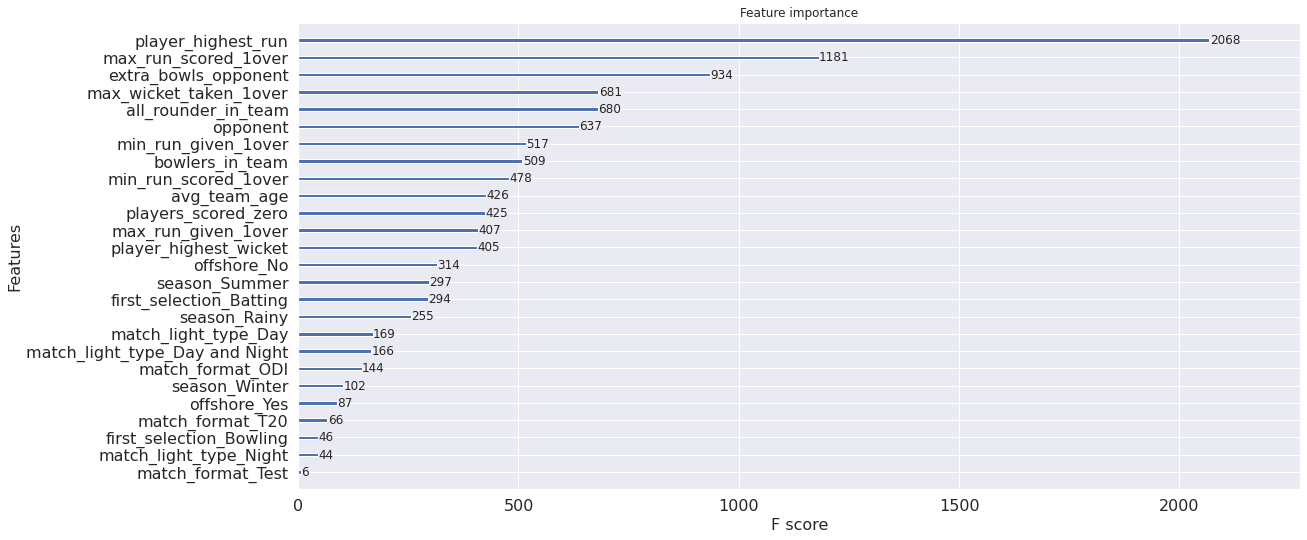

In [49]:
import xgboost as xgb
model.get_booster().feature_names = list(useful_cols)
xgb.plot_importance(model.get_booster())

In [ ]:
from sklearn.ensemble import  RandomForestClassifier

In [ ]:
def run(trial):

    for fold in range(5):
        xtrain =  df_maindata[df_maindata.kfold != fold].reset_index(drop=True)
        xvalid = df_maindata[df_maindata.kfold == fold].reset_index(drop=True)

        ytrain = xtrain.result
        yvalid = xvalid.result
        
        xtrain = xtrain[useful_cols]
        xvalid = xvalid[useful_cols]
        
        ordinal_encoder = preprocessing.OrdinalEncoder()
        xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
        xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
        
        # Optuna suggest params
        params = {
        'n_estimators':  trial.suggest_int("n_estimators", 2, 7000),
        'max_depth': int(trial.suggest_loguniform('max_depth', 1, 32))}


        
        model_rf = RandomForestClassifier(**params, random_state=7)
        
        
        model_rf.fit(xtrain, ytrain)
        
        preds_valid = model_rf.predict_proba(xvalid)[:, 1]
        roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    
        
    return roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(run, n_trials=30)

study.best_params

[I 2021-10-29 04:35:44,606] A new study created in memory with name: no-name-d4206657-0239-4623-9fec-94cba24b7660
[I 2021-10-29 04:36:25,055] Trial 0 finished with value: 0.9685265295312087 and parameters: {'n_estimators': 2456, 'max_depth': 23.980108596607867}. Best is trial 0 with value: 0.9685265295312087.
[I 2021-10-29 04:36:37,589] Trial 1 finished with value: 0.9695638739295488 and parameters: {'n_estimators': 761, 'max_depth': 30.76534737254473}. Best is trial 1 with value: 0.9695638739295488.
[I 2021-10-29 04:38:13,484] Trial 2 finished with value: 0.948684559018275 and parameters: {'n_estimators': 6274, 'max_depth': 10.079054915025806}. Best is trial 1 with value: 0.9695638739295488.
[I 2021-10-29 04:38:37,164] Trial 3 finished with value: 0.781495541626203 and parameters: {'n_estimators': 2715, 'max_depth': 1.1639100202689168}. Best is trial 1 with value: 0.9695638739295488.
[I 2021-10-29 04:39:15,589] Trial 4 finished with value: 0.8106956828816103 and parameters: {'n_estima

{'max_depth': 25.937543545849543, 'n_estimators': 528}

In [ ]:

df_test = df_test1[useful_cols]
final_test_predictions = []
final_valid_predictions = {}
decisions_valid = []
decisions_test = [] 
scores = []
for fold in range(5):
    xtrain =  df[df.kfold != fold].reset_index(drop=True)
    xvalid = df[df.kfold == fold].reset_index(drop=True)
    xtest = df_test.copy()
    
    valid_ids = xvalid.index.values.tolist()

    ytrain = xtrain.result
    yvalid = xvalid.result
    
    xtrain = xtrain[useful_cols]
    xvalid = xvalid[useful_cols]
    
    ordinal_encoder = preprocessing.OrdinalEncoder()
    xtrain[categorical] = ordinal_encoder.fit_transform(xtrain[categorical])
    xvalid[categorical] = ordinal_encoder.transform(xvalid[categorical])
    xtest[categorical] = ordinal_encoder.transform(xtest[categorical])
    
    model = RandomForestClassifier(
        random_state=0, 
        n_estimators=528,
        max_depth = int(25.937543545849543)
    )
    model.fit(xtrain, ytrain)
    preds_valid = model.predict_proba(xvalid)[:, 1]
    # decision_valid = (preds_valid >= 0.5)
    # decisions_valid.append(decision_valid)
    test_preds = model.predict_proba(xtest)[:, 1]
    # decision_test = (test_preds >= 0.5)
    # decisions_test.append(decision_test)
    final_test_predictions.append(test_preds)
    final_valid_predictions.update(dict(zip(valid_ids, preds_valid)))
    roc_auc = metrics.roc_auc_score(yvalid, preds_valid)
    print(fold, roc_auc)
    scores.append(roc_auc)
 
print(np.mean(scores), np.std(scores))

0 0.9446395068346288
1 0.9593821167445763
2 0.9578865336658354
3 0.9696221793349169
4 0.952124773960217
0.956731022108035 0.008270038790557023


<Figure size 1296x864 with 0 Axes>

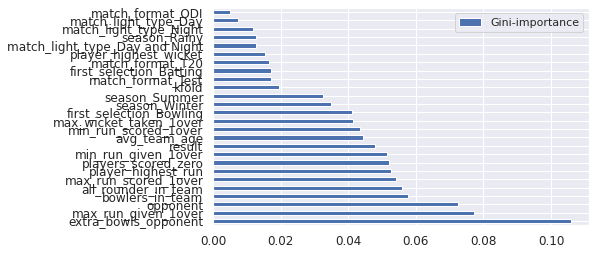

In [ ]:
import pandas as pd
%matplotlib inline
plt.figure(figsize = (18,12))
#do code to support model
#"data" is the X dataframe and model is the SKlearn object

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(df_maindata.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
(importances.sort_values(by='Gini-importance', ascending = False)).plot(kind='barh')

## **Test on the Given Series Condition:**

###  **1 Test match with England in England. All the match are day matches. In England, it will be rainy season at the time to match**


In [105]:
"""Opponent as england in Label Encoder is 2.0"""

"""1 Test match with England in England. All the match are day matches. In England, it will be rainy season at the time to match. """
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['England']).reshape(-1,1))
df_query['match_format_Test'] = 1
df_query['season_Rainy'] = 1
df_query['match_light_type_Day and Night'] = 0
df_query['match_format_T20'] = 0
df_query['offshore_No'] = 0
df_query['offshore_Yes'] = 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [106]:
# df_query['opponent'] = ordinal_encoder.transform(df_query['opponent'].values.reshape(-1,1))
model.predict(df_query)

array([1])

## **2 T20 match with Australia in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.**

In [118]:
"""2 T20 match with Australia in India. All the match are Day and Night matches. In India, it will be winter season at the time to match. """
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['Australia']).reshape(-1,1))
df_query['season_Rainy'] = 0
df_query['season_Winter'] = 1
df_query['match_light_type_Day and Night'] = 1
df_query['match_format_Test'] = 0
df_query['offshore_No'] = 1
df_query['offshore_Yes'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [121]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 0,
  'match_format_T20': 1,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 0.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]

In [120]:
model.predict(df_query)

array([1])

In [116]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 0,
  'match_format_T20': 1,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 0.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]

In [123]:
df_maindata.head(1)

,result,avg_team_age,bowlers_in_team,all_rounder_in_team,opponent,max_run_scored_1over,max_wicket_taken_1over,min_run_given_1over,min_run_scored_1over,max_run_given_1over,extra_bowls_opponent,player_highest_run,players_scored_zero,player_highest_wicket,kfold,match_light_type_Day,match_light_type_Day and Night,match_light_type_Night,match_format_ODI,match_format_T20,match_format_Test,first_selection_Batting,first_selection_Bowling,season_Rainy,season_Summer,season_Winter,offshore_No,offshore_Yes
0,0,24.0,3.0,3.0,Srilanka,13.0,3,2,3.0,6.0,0,54.0,3,1,1,1,0,0,1,0,0,0,1,0,1,0,1,0


### **2 ODI match with Sri Lanka in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.**

In [124]:
#  2 ODI match with Sri Lanka in India. All the match are Day and Night matches. In India, it will be winter season at the time to match.
df_query = df_test.head(1)
df_query['opponent'] = ordinal_encoder.transform(np.array(['Srilanka']).reshape(-1,1))
df_query['match_format_ODI'] = 1
df_query['match_format_T20'] = 0
df_query['season_Rainy'] = 0
df_query['season_Winter'] = 1
df_query['match_light_type_Day and Night'] = 1
df_query['match_format_Test'] = 0
df_query['offshore_No'] = 1
df_query['offshore_Yes'] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [125]:
model.predict(df_query)

array([1])

In [126]:
df_query.to_dict(orient='records')

[{'all_rounder_in_team': 4.0,
  'avg_team_age': 30.0,
  'bowlers_in_team': 2.0,
  'extra_bowls_opponent': 2,
  'first_selection_Batting': 0,
  'first_selection_Bowling': 1,
  'match_format_ODI': 1,
  'match_format_T20': 0,
  'match_format_Test': 0,
  'match_light_type_Day': 0,
  'match_light_type_Day and Night': 1,
  'match_light_type_Night': 0,
  'max_run_given_1over': 6.0,
  'max_run_scored_1over': 11.0,
  'max_wicket_taken_1over': 4,
  'min_run_given_1over': 0,
  'min_run_scored_1over': 3.0,
  'offshore_No': 1,
  'offshore_Yes': 0,
  'opponent': 6.0,
  'player_highest_run': 54.0,
  'player_highest_wicket': 2,
  'players_scored_zero': 3,
  'season_Rainy': 0,
  'season_Summer': 0,
  'season_Winter': 1}]